# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
filename = 'casa-kmeans'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/casa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [7]:
data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


# BUILD DATASET & DATALOADERS

In [10]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [11]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [12]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [13]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [14]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 25

In [16]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [18]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            ['fuel', 'machine', 'others', 'part', 'price', 'service']
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [19]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def kmeans_clustering_sampling(aspect_model, sentiment_model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    current_train_size = len(train_indices)
    aspect_dataset = AspectDetectionDataset(
        X_pool, 
        [['neutral' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    start_time = time.time()

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
            embeddings = aspect_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        for i in range(len(outputs)):
            aspect_outputs[batch['ori_indices'][i].item()] = embeddings.last_hidden_state[i].mean(dim=1).cpu().numpy()
            
            for j in range(len(outputs[i])):
                if int(outputs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    if len(data) > 0:
        sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
        sentiment_loader = torch.utils.data.DataLoader(
            sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
        )
    
        # Pass through sentiment analysis model
        for batch in sentiment_loader:
            token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
    
            with torch.no_grad():
                outputs = sentiment_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    
            for i in range(len(outputs.last_hidden_state)):
                ori_index = batch['ori_indices'][i].item()
                if ori_index in sentiment_outputs.keys():
                    sentiment_outputs[ori_index].append(outputs.last_hidden_state[i].mean(dim=1).cpu().numpy())
                else:
                    sentiment_outputs[ori_index] = [outputs.last_hidden_state[i].mean(dim=1).cpu().numpy()]

    for key, val in sentiment_outputs.items():
        sentiment_outputs[key] = np.mean(val, axis=0)

    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    if accelerator.is_main_process:
        aspect_outputs = dict(sorted(aspect_outputs.items()))

        if len(data) > 0:
            for key, val in sentiment_outputs.items():
                aspect_outputs[key] = np.mean([val, aspect_outputs[key]], axis=0)

        embeddings = np.array(list(aspect_outputs.values()))
        target_samples = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'fuel': [y_train[i][0] for i in temp],
                'machine': [y_train[i][1] for i in temp],
                'others': [y_train[i][2] for i in temp],
                'part': [y_train[i][3] for i in temp],
                'price': [y_train[i][4] for i in temp],
                'service': [y_train[i][5] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(embeddings)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 10)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances <= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'fuel': [y_train[i][0] for i in temp],
                    'machine': [y_train[i][1] for i in temp],
                    'others': [y_train[i][2] for i in temp],
                    'part': [y_train[i][3] for i in temp],
                    'price': [y_train[i][4] for i in temp],
                    'service': [y_train[i][5] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [21]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed
        )
        notebook_launcher(train_model, args, num_processes=2)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [22]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6756, Accuracy: 0.7731, F1 Micro: 0.8711, F1 Macro: 0.8698
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5958, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5785, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.513, Accuracy: 0.7939, F1 Micro: 0.8843, F1 Macro: 0.8828
Epoch 5/10, Train Loss: 0.5006, Accuracy: 0.7924, F1 Micro: 0.8829, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4695, Accuracy: 0.7954, F1 Micro: 0.8846, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4328, Accuracy: 0.7969, F1 Micro: 0.8857, F1 Macro: 0.8842
Epoch 8/10, Train Loss: 0.4369, Accuracy: 0.7932, F1 Micro: 0.8832, F1 Macro: 0.8812
Epoch 9/10, Train Loss: 0.415, Accuracy: 0.7917, F1 Micro: 0.8816, F1 Macro: 0.8789
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7162, Accuracy: 0.2857, F1 Micro: 0.2857, F1 Macro: 0.2222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6764, Accuracy: 0.5, F1 Micro: 0.5, F1 Macro: 0.4974
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6621, Accuracy: 0.7143, F1 Micro: 0.7143, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.6053, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5803, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5674, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4789, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4895, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Epoch 9/10, Train Loss: 0.4054, Accuracy: 0.7143, F1 Micro: 0.7143,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6396, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5592, Accuracy: 0.7917, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5227, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Epoch 4/10, Train Loss: 0.5045, Accuracy: 0.7917, F1 Micro: 0.8833, F1 Macro: 0.8819
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4576, Accuracy: 0.8051, F1 Micro: 0.8898, F1 Macro: 0.8885
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4176, Accuracy: 0.817, F1 Micro: 0.8954, F1 Macro: 0.8943
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.412, Accuracy: 0.8371, F1 Micro: 0.9046, F1 Macro: 0.9035
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3537, Accuracy: 0.8549, F1 Micro: 0.9141, F1 Macro: 0.913
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3009, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6601, Accuracy: 0.7053, F1 Micro: 0.7053, F1 Macro: 0.4136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4924, Accuracy: 0.7053, F1 Micro: 0.7053, F1 Macro: 0.4136
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4551, Accuracy: 0.8895, F1 Micro: 0.8895, F1 Macro: 0.8649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3052, Accuracy: 0.8947, F1 Micro: 0.8947, F1 Macro: 0.8771
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2396, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8827
Epoch 6/10, Train Loss: 0.1603, Accuracy: 0.8895, F1 Micro: 0.8895, F1 Macro: 0.8758
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8894
Epoch 8/10, Train Loss: 0.1067, Accuracy: 0.8789, F1 Micro: 0.8789, F1 Macro: 0.8629
Epoch 9/10, Train Loss: 0.0612, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8764
Epoch 10/10, Train Loss: 0.0557, Accuracy: 0.8421

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6055, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5367, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5003, Accuracy: 0.7946, F1 Micro: 0.8848, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4741, Accuracy: 0.814, F1 Micro: 0.8943, F1 Macro: 0.8936
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4156, Accuracy: 0.8549, F1 Micro: 0.915, F1 Macro: 0.9149
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3722, Accuracy: 0.8943, F1 Micro: 0.9365, F1 Macro: 0.9355
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3215, Accuracy: 0.9182, F1 Micro: 0.9498, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.263, Accuracy: 0.933, F1 Micro: 0.9584, F1 Macro: 0.9567
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6454, Accuracy: 0.6696, F1 Micro: 0.6696, F1 Macro: 0.4011
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4976, Accuracy: 0.7093, F1 Micro: 0.7093, F1 Macro: 0.5266
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3915, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2361, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Macro: 0.9182
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.207, Accuracy: 0.9295, F1 Micro: 0.9295, F1 Macro: 0.9214
Epoch 6/10, Train Loss: 0.1298, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8961
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.9075, F1 Micro: 0.9075, F1 Macro: 0.8936
Epoch 8/10, Train Loss: 0.1123, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9086
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9075
Epoch 10/10, Train Loss: 0.0894, Accuracy: 0.9207, F1 Micro: 0.9207, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5965, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5105, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4865, Accuracy: 0.7961, F1 Micro: 0.8855, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4198, Accuracy: 0.8393, F1 Micro: 0.9067, F1 Macro: 0.9059
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3625, Accuracy: 0.8876, F1 Micro: 0.933, F1 Macro: 0.9319
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3094, Accuracy: 0.9256, F1 Micro: 0.9541, F1 Macro: 0.9525
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.238, Accuracy: 0.9427, F1 Micro: 0.9645, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2012, Accuracy: 0.9457, F1 Micro: 0.9663, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5724, Accuracy: 0.6827, F1 Micro: 0.6827, F1 Macro: 0.4057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3991, Accuracy: 0.8755, F1 Micro: 0.8755, F1 Macro: 0.8558
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.8956, F1 Micro: 0.8956, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.911
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8915
Epoch 6/10, Train Loss: 0.1075, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.9023
Epoch 7/10, Train Loss: 0.1114, Accuracy: 0.8675, F1 Micro: 0.8675, F1 Macro: 0.8593
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.075, Accuracy: 0.9317, F1 Micro: 0.9317, F1 Macro: 0.9247
Epoch 9/10, Train Loss: 0.0758, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.9038
Epoch 10/10, Train Loss: 0.076, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5842, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Epoch 2/10, Train Loss: 0.5095, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4421, Accuracy: 0.8333, F1 Micro: 0.9029, F1 Macro: 0.9023
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3902, Accuracy: 0.8914, F1 Micro: 0.9346, F1 Macro: 0.934
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2999, Accuracy: 0.9368, F1 Micro: 0.9608, F1 Macro: 0.9593
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2368, Accuracy: 0.9457, F1 Micro: 0.9663, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1916, Accuracy: 0.9487, F1 Micro: 0.968, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1546, Accuracy: 0.9524, F1 Micro: 0.9701, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1264, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5716, Accuracy: 0.7439, F1 Micro: 0.7439, F1 Macro: 0.6076
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.27, Accuracy: 0.8943, F1 Micro: 0.8943, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1422, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.932
Epoch 4/10, Train Loss: 0.1485, Accuracy: 0.9187, F1 Micro: 0.9187, F1 Macro: 0.912
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.8943, F1 Micro: 0.8943, F1 Macro: 0.8876
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.9041
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9268, F1 Micro: 0.9268, F1 Macro: 0.92
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.9309, F1 Micro: 0.9309, F1 Macro: 0.9242
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.9268, F1 Micro: 0.9268, F1 Macro: 0.9195
Epoch 10/10, Train Loss: 0.057, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9166

Sentiment analysis accuracy: 0.939, F1 Micro: 0.939, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5672, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4924, Accuracy: 0.8095, F1 Micro: 0.892, F1 Macro: 0.891
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4181, Accuracy: 0.8586, F1 Micro: 0.9172, F1 Macro: 0.9164
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3292, Accuracy: 0.9256, F1 Micro: 0.9541, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2498, Accuracy: 0.9442, F1 Micro: 0.9653, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1868, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1417, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1263, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9714
Epoch 9/10, Train Loss: 0.1041, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5818, Accuracy: 0.8224, F1 Micro: 0.8224, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2782, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9058
Epoch 3/10, Train Loss: 0.1659, Accuracy: 0.8919, F1 Micro: 0.8919, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1604, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9063
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1324, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9239
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9221
Epoch 7/10, Train Loss: 0.1044, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9249
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9189
Epoch 10/10, Train Loss: 0.072, Accuracy: 0.9266, F1 Micro: 0.9266, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5701, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5011, Accuracy: 0.814, F1 Micro: 0.8942, F1 Macro: 0.8934
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4083, Accuracy: 0.8958, F1 Micro: 0.9373, F1 Macro: 0.9366
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3085, Accuracy: 0.9405, F1 Micro: 0.9632, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2334, Accuracy: 0.9501, F1 Micro: 0.9688, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1771, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1424, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9776
Epoch 8/10, Train Loss: 0.1084, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.0931, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5434, Accuracy: 0.8386, F1 Micro: 0.8386, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2848, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8973
Epoch 3/10, Train Loss: 0.1324, Accuracy: 0.8622, F1 Micro: 0.8622, F1 Macro: 0.8554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1213, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9153
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.9063
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9293
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1046, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9293
Epoch 9/10, Train Loss: 0.065, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9218
Epoch 10/10, Train Loss: 0.0681, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5563, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.476, Accuracy: 0.8192, F1 Micro: 0.8971, F1 Macro: 0.8963
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3795, Accuracy: 0.9174, F1 Micro: 0.9498, F1 Macro: 0.9485
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2712, Accuracy: 0.9472, F1 Micro: 0.9672, F1 Macro: 0.9656
Epoch 5/10, Train Loss: 0.2126, Accuracy: 0.9472, F1 Micro: 0.967, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1516, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1297, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1093, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9732
Epoch 9/10, Train Loss: 0.0914, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5837, Accuracy: 0.8849, F1 Micro: 0.8849, F1 Macro: 0.8629
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2681, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9343
Epoch 3/10, Train Loss: 0.1865, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8932
Epoch 4/10, Train Loss: 0.1268, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9256
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9425
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9099
Epoch 7/10, Train Loss: 0.0911, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.929
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9264
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9305
Epoch 10/10, Train Loss: 0.0538, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9343

Sentiment analysis accuracy: 0.9484, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5549, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4568, Accuracy: 0.8519, F1 Micro: 0.914, F1 Macro: 0.9137
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3568, Accuracy: 0.9338, F1 Micro: 0.9593, F1 Macro: 0.9577
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2433, Accuracy: 0.9405, F1 Micro: 0.9629, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1865, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1454, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1188, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.0916, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9755
Epoch 9/10, Train Loss: 0.0813, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5418, Accuracy: 0.8452, F1 Micro: 0.8452, F1 Macro: 0.8027
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.27, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9277
Epoch 3/10, Train Loss: 0.1659, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9252
Epoch 4/10, Train Loss: 0.1543, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9252
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1163, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9294
Epoch 6/10, Train Loss: 0.1004, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.8971
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9229
Epoch 8/10, Train Loss: 0.0756, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9164
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9173
Epoch 10/10, Train Loss: 0.0603, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9243

Sentiment analysis accuracy: 0.9365, F1 Micro: 0.93

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5546, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4683, Accuracy: 0.8296, F1 Micro: 0.9025, F1 Macro: 0.9019
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3603, Accuracy: 0.9308, F1 Micro: 0.9573, F1 Macro: 0.9555
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2584, Accuracy: 0.9516, F1 Micro: 0.9697, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1893, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9733
Epoch 6/10, Train Loss: 0.1513, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1212, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.0955, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5142, Accuracy: 0.8911, F1 Micro: 0.8911, F1 Macro: 0.8692
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2793, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.89
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.17, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9231
Epoch 4/10, Train Loss: 0.1428, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.9029
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9186
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1127, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9259
Epoch 7/10, Train Loss: 0.1093, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.919
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9218
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8984
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0367, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.93

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.557, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4661, Accuracy: 0.8311, F1 Micro: 0.9032, F1 Macro: 0.9022
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3465, Accuracy: 0.9345, F1 Micro: 0.9593, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2511, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.176, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1388, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Epoch 7/10, Train Loss: 0.1088, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9744
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5229, Accuracy: 0.8496, F1 Micro: 0.8496, F1 Macro: 0.7985
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2253, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.924
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8969
Epoch 4/10, Train Loss: 0.1449, Accuracy: 0.8985, F1 Micro: 0.8985, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9321
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1147, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9313
Epoch 7/10, Train Loss: 0.1107, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.913
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.92
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.043, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5432, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4528, Accuracy: 0.8348, F1 Micro: 0.9051, F1 Macro: 0.9046
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3375, Accuracy: 0.9368, F1 Micro: 0.9608, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2272, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1709, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.132, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.105, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 8/10, Train Loss: 0.0871, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4567, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9025
Epoch 2/10, Train Loss: 0.2661, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.9007
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1493, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9506, F1 Micro: 0.9506, F1 Macro: 0.9437
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9125
Epoch 7/10, Train Loss: 0.0918, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9358
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9358
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9276
Epoch 10/10, Train Loss: 0.0509, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9276

Sentiment analysis accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5557, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4484, Accuracy: 0.8519, F1 Micro: 0.9138, F1 Macro: 0.9132
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3199, Accuracy: 0.9368, F1 Micro: 0.9608, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2144, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1601, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1211, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9747
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4965, Accuracy: 0.8858, F1 Micro: 0.8858, F1 Macro: 0.8644
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.201, Accuracy: 0.8858, F1 Micro: 0.8858, F1 Macro: 0.8773
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.146, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9181
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1402, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9255
Epoch 5/10, Train Loss: 0.1413, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9185
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9327
Epoch 7/10, Train Loss: 0.0855, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9185
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.082, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9388
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.9058
Epoch 10/10, Train Loss: 0.0724, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5358, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4432, Accuracy: 0.8996, F1 Micro: 0.9395, F1 Macro: 0.9384
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3037, Accuracy: 0.9405, F1 Micro: 0.9629, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2076, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0918, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.0773, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9739
Epoch 9/10, Train Loss: 0.0628, Accuracy: 0.9613, F1 Micro: 0.9757, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5033, Accuracy: 0.8915, F1 Micro: 0.8915, F1 Macro: 0.8723
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2183, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9128
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1552, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9252
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9151
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1081, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9348
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9314
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.9071
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9151
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9192
Epoch 10/10, Train Loss: 0.0492, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9179

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5453, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4398, Accuracy: 0.9122, F1 Micro: 0.9467, F1 Macro: 0.9453
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3049, Accuracy: 0.9479, F1 Micro: 0.9678, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2053, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1495, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9785
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9737
Epoch 8/10, Train Loss: 0.0762, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5117, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9129
Epoch 2/10, Train Loss: 0.1833, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8975
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1692, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9415
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.123, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9415
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.098, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9426
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9526, F1 Micro: 0.9526, F1 Macro: 0.9465
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9345
Epoch 8/10, Train Loss: 0.0777, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.9061
Epoch 9/10, Train Loss: 0.0874, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9423
Epoch 10/10, Train Loss: 0.0741, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5391, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4472, Accuracy: 0.9055, F1 Micro: 0.9432, F1 Macro: 0.9424
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2981, Accuracy: 0.9464, F1 Micro: 0.9667, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2033, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1398, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9748
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.073, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.0633, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4668, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.909
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2302, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.9099
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1874, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1371, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9371
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1475, Accuracy: 0.9515, F1 Micro: 0.9515, F1 Macro: 0.9452
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9177
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9172
Epoch 8/10, Train Loss: 0.0727, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9287
Epoch 9/10, Train Loss: 0.0653, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9212
Epoch 10/10, Train Loss: 0.0573, Accuracy: 0.9254, F1 Micro: 0.9254, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5445, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.429, Accuracy: 0.904, F1 Micro: 0.9416, F1 Macro: 0.9404
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2836, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1964, Accuracy: 0.9516, F1 Micro: 0.9696, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9747
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9724
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0716, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5055, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.9006
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2211, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9183
Epoch 3/10, Train Loss: 0.1431, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8991
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9261
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8991
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9314
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9187
Epoch 8/10, Train Loss: 0.0989, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.922
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9187
Epoch 10/10, Train Loss: 0.047, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.9031

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5317, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4175, Accuracy: 0.9062, F1 Micro: 0.9432, F1 Macro: 0.9418
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.27, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1806, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9784
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9795
Epoch 7/10, Train Loss: 0.0866, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9744
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9752
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4795, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9099
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2072, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9121
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1753, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.133, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9398
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9197
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9439
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9291
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9201
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9054
Epoch 10/10, Train Loss: 0.064, Accuracy: 0.9344, F1 Micro: 0.9344, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5396, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4195, Accuracy: 0.9167, F1 Micro: 0.9494, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2652, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.185, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9805
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9798
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.98
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4777, Accuracy: 0.8735, F1 Micro: 0.8735, F1 Macro: 0.8646
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2118, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8988
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1769, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9269
Epoch 4/10, Train Loss: 0.1356, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9187
Epoch 5/10, Train Loss: 0.1386, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9228
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.9061
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9187
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0709, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9387
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9345
Epoch 10/10, Train Loss: 0.0577, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9249

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5349, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4195, Accuracy: 0.9115, F1 Micro: 0.9467, F1 Macro: 0.9458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2597, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1764, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9776
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.9621, F1 Micro: 0.9759, F1 Macro: 0.9736
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4593, Accuracy: 0.8872, F1 Micro: 0.8872, F1 Macro: 0.8783
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2031, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1442, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9415
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1495, Accuracy: 0.9511, F1 Micro: 0.9511, F1 Macro: 0.9446
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9292
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9402
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.9586, F1 Micro: 0.9586, F1 Macro: 0.9532
Epoch 8/10, Train Loss: 0.0727, Accuracy: 0.8985, F1 Micro: 0.8985, F1 Macro: 0.8902
Epoch 9/10, Train Loss: 0.0789, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.916
Epoch 10/10, Train Loss: 0.0644, Accuracy: 0.9398, F1 Micro: 0.9398, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5226, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4111, Accuracy: 0.9234, F1 Micro: 0.9531, F1 Macro: 0.9516
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2517, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1683, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9764
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9781
Epoch 7/10, Train Loss: 0.0799, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9746
Epoch 8/10, Train Loss: 0.0623, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9688, F1 Micro: 0.9802, F1 Macro: 0.9789
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4675, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8951
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2066, Accuracy: 0.9446, F1 Micro: 0.9446, F1 Macro: 0.9381
Epoch 3/10, Train Loss: 0.1657, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.9446, F1 Micro: 0.9446, F1 Macro: 0.9381
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9291
Epoch 6/10, Train Loss: 0.1082, Accuracy: 0.9299, F1 Micro: 0.9299, F1 Macro: 0.9212
Epoch 7/10, Train Loss: 0.0942, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9295
Epoch 8/10, Train Loss: 0.0773, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9243
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8994
Epoch 10/10, Train Loss: 0.0554, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9143

Sentiment analysis accuracy: 0.9446, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5307, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3947, Accuracy: 0.9308, F1 Micro: 0.9575, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.256, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.132, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9782
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9805
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.486, Accuracy: 0.8696, F1 Micro: 0.8696, F1 Macro: 0.8628
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2762, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9212
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1473, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9224
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1117, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9387
Epoch 5/10, Train Loss: 0.1054, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9334
Epoch 6/10, Train Loss: 0.1262, Accuracy: 0.8893, F1 Micro: 0.8893, F1 Macro: 0.8825
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9345
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9283
Epoch 9/10, Train Loss: 0.0606, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.898
Epoch 10/10, Train Loss: 0.0499, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.8925

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.524, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3784, Accuracy: 0.9271, F1 Micro: 0.955, F1 Macro: 0.9527
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2385, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4647, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9369
Epoch 2/10, Train Loss: 0.2141, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.9061
Epoch 3/10, Train Loss: 0.1546, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9317
Epoch 4/10, Train Loss: 0.1381, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9335
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.8872, F1 Micro: 0.8872, F1 Macro: 0.8793
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9335
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9213
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9296
Epoch 9/10, Train Loss: 0.065, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9134
Epoch 10/10, Train Loss: 0.0794, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9256

Sentiment analysis accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9369
              precision    recall  f1-score 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.529, Accuracy: 0.8006, F1 Micro: 0.8879, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3937, Accuracy: 0.9338, F1 Micro: 0.9589, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2506, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Macro: 0.9801
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9798
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9747, F1 Micro: 0.9841, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.479, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9159
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2153, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9251
Epoch 3/10, Train Loss: 0.1706, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9137
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9243
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1132, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9371
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9215
Epoch 7/10, Train Loss: 0.089, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9255
Epoch 8/10, Train Loss: 0.0749, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9215
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9243
Epoch 10/10, Train Loss: 0.0593, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9247

Sentiment analysis

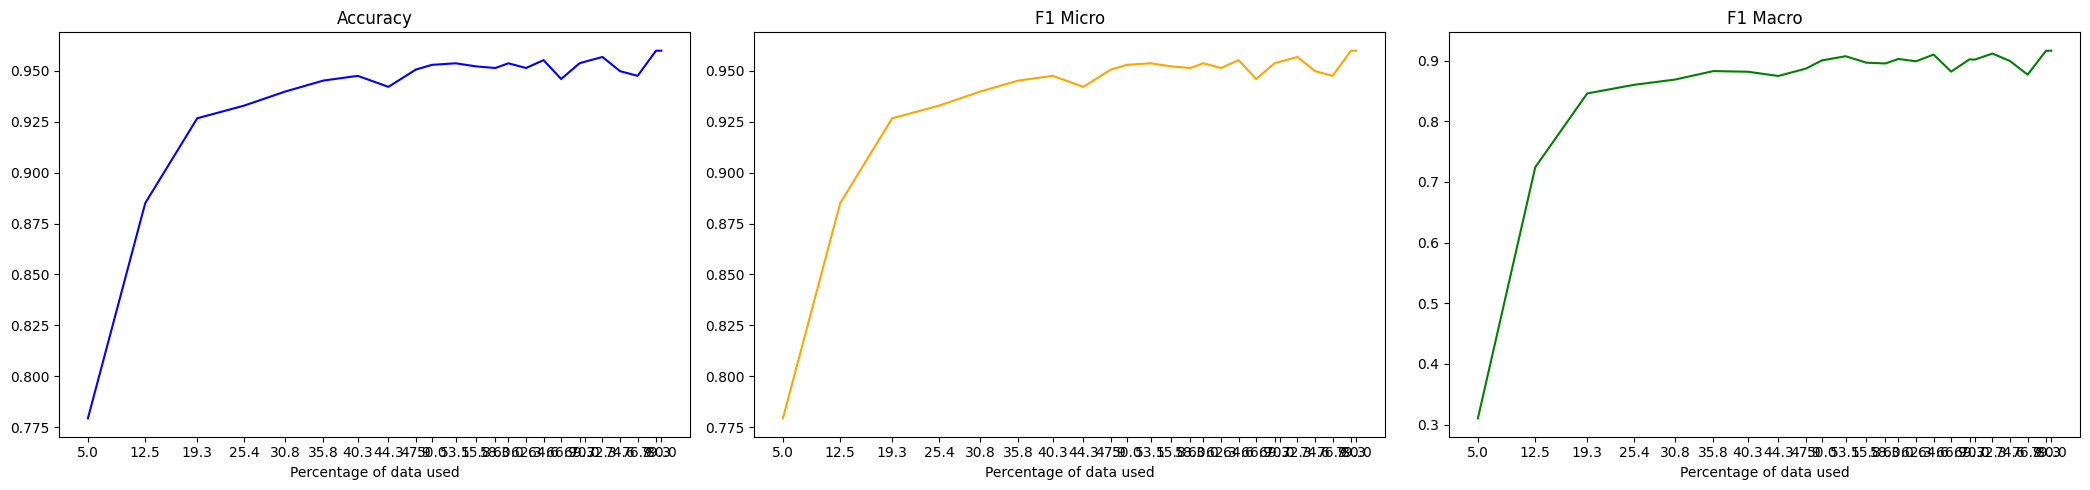

In [23]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.647, Accuracy: 0.7054, F1 Micro: 0.8127, F1 Macro: 0.7262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5731, Accuracy: 0.7374, F1 Micro: 0.8408, F1 Macro: 0.7949
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5493, Accuracy: 0.7917, F1 Micro: 0.8824, F1 Macro: 0.8802
Epoch 4/10, Train Loss: 0.5049, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Epoch 5/10, Train Loss: 0.4781, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 6/10, Train Loss: 0.4364, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4061, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Epoch 8/10, Train Loss: 0.4421, Accuracy: 0.7902, F1 Micro: 0.8825, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4208, Accuracy: 0.7939, F1 Micro: 0.8842, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6351, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5577, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5004, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4905, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4593, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4341, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4188, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2323, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6019, Accuracy: 0.7939, F1 Micro: 0.8843, F1 Macro: 0.8828
Epoch 2/10, Train Loss: 0.5087, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.4912, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 4/10, Train Loss: 0.4678, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4064, Accuracy: 0.8013, F1 Micro: 0.8882, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3727, Accuracy: 0.8408, F1 Micro: 0.9079, F1 Macro: 0.907
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3457, Accuracy: 0.8735, F1 Micro: 0.9244, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2998, Accuracy: 0.8862, F1 Micro: 0.9306, F1 Macro: 0.9286
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2753, Accuracy: 0.907, F1 Micro: 0.9432, F1 Macro: 0.9413
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6965, Accuracy: 0.6901, F1 Micro: 0.6901, F1 Macro: 0.4225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5869, Accuracy: 0.6901, F1 Micro: 0.6901, F1 Macro: 0.4225
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5192, Accuracy: 0.8122, F1 Micro: 0.8122, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3838, Accuracy: 0.8404, F1 Micro: 0.8404, F1 Macro: 0.8251
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.26, Accuracy: 0.8592, F1 Micro: 0.8592, F1 Macro: 0.8437
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2092, Accuracy: 0.8826, F1 Micro: 0.8826, F1 Macro: 0.8645
Epoch 7/10, Train Loss: 0.1656, Accuracy: 0.8498, F1 Micro: 0.8498, F1 Macro: 0.8363
Epoch 8/10, Train Loss: 0.1089, Accuracy: 0.8732, F1 Micro: 0.8732, F1 Macro: 0.8579
Epoch 9/10, Train Loss: 0.1778, Accuracy: 0.8638, F1 Micro: 0.8638, F1 Macro: 0.8494
Epoch 10/10, Train Loss: 0.0705, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5969, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5152, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.496, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4594, Accuracy: 0.8088, F1 Micro: 0.8917, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3922, Accuracy: 0.8653, F1 Micro: 0.9202, F1 Macro: 0.9191
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3328, Accuracy: 0.8884, F1 Micro: 0.9318, F1 Macro: 0.9297
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.281, Accuracy: 0.9122, F1 Micro: 0.9461, F1 Macro: 0.9441
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2356, Accuracy: 0.9256, F1 Micro: 0.954, F1 Macro: 0.9521
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5866, Accuracy: 0.6831, F1 Micro: 0.6831, F1 Macro: 0.4059
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5052, Accuracy: 0.8272, F1 Micro: 0.8272, F1 Macro: 0.7911
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2931, Accuracy: 0.8765, F1 Micro: 0.8765, F1 Macro: 0.8611
Epoch 4/10, Train Loss: 0.1783, Accuracy: 0.8724, F1 Micro: 0.8724, F1 Macro: 0.8629
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.893, F1 Micro: 0.893, F1 Macro: 0.8764
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.8848, F1 Micro: 0.8848, F1 Macro: 0.8753
Epoch 7/10, Train Loss: 0.1028, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.077, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.8908
Epoch 9/10, Train Loss: 0.1269, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8878
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0972, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5829, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5029, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4577, Accuracy: 0.8125, F1 Micro: 0.8938, F1 Macro: 0.8925
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4008, Accuracy: 0.8787, F1 Micro: 0.9278, F1 Macro: 0.9269
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3299, Accuracy: 0.9077, F1 Micro: 0.9434, F1 Macro: 0.9413
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2676, Accuracy: 0.9256, F1 Micro: 0.9542, F1 Macro: 0.9528
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2201, Accuracy: 0.9397, F1 Micro: 0.9627, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1737, Accuracy: 0.9449, F1 Micro: 0.9658, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6264, Accuracy: 0.6681, F1 Micro: 0.6681, F1 Macro: 0.4005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5044, Accuracy: 0.8613, F1 Micro: 0.8613, F1 Macro: 0.8494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2748, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.9004
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1622, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9296
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9256
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9448
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0934, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9435
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.949
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.099, Accuracy: 0.9538, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5751, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.491, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4383, Accuracy: 0.8348, F1 Micro: 0.9051, F1 Macro: 0.9043
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3501, Accuracy: 0.9085, F1 Micro: 0.9444, F1 Macro: 0.9432
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2697, Accuracy: 0.9286, F1 Micro: 0.9563, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2178, Accuracy: 0.9427, F1 Micro: 0.9644, F1 Macro: 0.9629
Epoch 7/10, Train Loss: 0.169, Accuracy: 0.942, F1 Micro: 0.9637, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.138, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9694
Epoch 9/10, Train Loss: 0.1125, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.581, Accuracy: 0.6816, F1 Micro: 0.6816, F1 Macro: 0.4288
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4285, Accuracy: 0.8816, F1 Micro: 0.8816, F1 Macro: 0.869
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.234, Accuracy: 0.9184, F1 Micro: 0.9184, F1 Macro: 0.9118
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.8653, F1 Micro: 0.8653, F1 Macro: 0.8584
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1576, Accuracy: 0.9388, F1 Micro: 0.9388, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9469, F1 Micro: 0.9469, F1 Macro: 0.9402
Epoch 7/10, Train Loss: 0.1503, Accuracy: 0.8857, F1 Micro: 0.8857, F1 Macro: 0.8787
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9388, F1 Micro: 0.9388, F1 Macro: 0.9326
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0928, Accuracy: 0.9551, F1 Micro: 0.9551, F1 Macro: 0.95
Epoch 10/10, Train Loss: 0.0577, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5509, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4727, Accuracy: 0.7991, F1 Micro: 0.8871, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3843, Accuracy: 0.8876, F1 Micro: 0.9324, F1 Macro: 0.9308
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.294, Accuracy: 0.9271, F1 Micro: 0.9552, F1 Macro: 0.9533
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2287, Accuracy: 0.9427, F1 Micro: 0.9644, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1722, Accuracy: 0.9464, F1 Micro: 0.9665, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1346, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1101, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9713
Epoch 9/10, Train Loss: 0.0912, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.557, Accuracy: 0.6897, F1 Micro: 0.6897, F1 Macro: 0.4309
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2971, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8919
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1968, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9431
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9265
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8998
Epoch 6/10, Train Loss: 0.1087, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9344
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9201
Epoch 8/10, Train Loss: 0.1249, Accuracy: 0.8927, F1 Micro: 0.8927, F1 Macro: 0.8847
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.922
Epoch 10/10, Train Loss: 0.0528, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9081

Sentiment analysis accuracy: 0.9502, F1 Micro: 0.9502, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5508, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4743, Accuracy: 0.8088, F1 Micro: 0.892, F1 Macro: 0.8906
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3719, Accuracy: 0.9077, F1 Micro: 0.9438, F1 Macro: 0.9421
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.288, Accuracy: 0.9338, F1 Micro: 0.9592, F1 Macro: 0.9577
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2154, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.17, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9695
Epoch 7/10, Train Loss: 0.1285, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1043, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0842, Accuracy: 0.95

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5163, Accuracy: 0.7004, F1 Micro: 0.7004, F1 Macro: 0.4768
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3216, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9105
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2055, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9126
Epoch 4/10, Train Loss: 0.1576, Accuracy: 0.8599, F1 Micro: 0.8599, F1 Macro: 0.8527
Epoch 5/10, Train Loss: 0.0983, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.9069
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.146, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9147
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9347
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5427, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4614, Accuracy: 0.811, F1 Micro: 0.8931, F1 Macro: 0.8919
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3556, Accuracy: 0.9219, F1 Micro: 0.9519, F1 Macro: 0.9501
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2728, Accuracy: 0.9435, F1 Micro: 0.965, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2028, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1623, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1287, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9733
Epoch 8/10, Train Loss: 0.1015, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9709
Epoch 9/10, Train Loss: 0.0792, Accuracy: 0.9516, F1 Micro: 0.9695, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5895, Accuracy: 0.686, F1 Micro: 0.686, F1 Macro: 0.4185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3294, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8947
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1879, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9142
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.922
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.9071
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.091, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9269
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9173
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1056, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9298
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9102
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5452, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4553, Accuracy: 0.8534, F1 Micro: 0.9147, F1 Macro: 0.9138
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.325, Accuracy: 0.9226, F1 Micro: 0.9524, F1 Macro: 0.9503
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2355, Accuracy: 0.9472, F1 Micro: 0.9671, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1801, Accuracy: 0.9509, F1 Micro: 0.9695, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.132, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0775, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9727
Epoch 9/10, Train Loss: 0.0681, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5568, Accuracy: 0.683, F1 Micro: 0.683, F1 Macro: 0.4058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.349, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9266
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.889
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9303
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9207
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1096, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9298
Epoch 7/10, Train Loss: 0.1253, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9168
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9319
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0846, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9367
Epoch 10/10, Train Loss: 0.0728, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5426, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4544, Accuracy: 0.8571, F1 Micro: 0.9167, F1 Macro: 0.9159
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3336, Accuracy: 0.9211, F1 Micro: 0.9515, F1 Macro: 0.9502
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2395, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9659
Epoch 5/10, Train Loss: 0.1781, Accuracy: 0.9472, F1 Micro: 0.9668, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1366, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.105, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9714
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0689, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5574, Accuracy: 0.6824, F1 Micro: 0.6824, F1 Macro: 0.4387
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3232, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9348
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1864, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9399
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1792, Accuracy: 0.9569, F1 Micro: 0.9569, F1 Macro: 0.9516
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9479
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9228
Epoch 7/10, Train Loss: 0.0857, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9479
Epoch 8/10, Train Loss: 0.0826, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9393
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9113
Epoch 10/10, Train Loss: 0.0433, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9389

Sentiment analys

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5387, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4443, Accuracy: 0.8683, F1 Micro: 0.9223, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3231, Accuracy: 0.9323, F1 Micro: 0.958, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2248, Accuracy: 0.9516, F1 Micro: 0.9701, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1756, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9724
Epoch 6/10, Train Loss: 0.1276, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9711
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.9554, F1 Micro: 0.9718, F1 Macro: 0.9702
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5462, Accuracy: 0.8721, F1 Micro: 0.8721, F1 Macro: 0.8539
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.8915, F1 Micro: 0.8915, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1838, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8996
Epoch 4/10, Train Loss: 0.1823, Accuracy: 0.8915, F1 Micro: 0.8915, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0881, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9273
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0682, Accuracy: 0.9341, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.542, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4391, Accuracy: 0.8891, F1 Micro: 0.934, F1 Macro: 0.9328
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3131, Accuracy: 0.939, F1 Micro: 0.9622, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2195, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1662, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.976
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9726
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0673, Accuracy: 0.9561, F1 Micro: 0.9722, F1 Macro: 0.97
Epoch 10/10, Train Loss: 0.0594, Accuracy: 0.9628, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5408, Accuracy: 0.8532, F1 Micro: 0.8532, F1 Macro: 0.8434
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.906
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.166, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9243
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9226
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1347, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9353
Epoch 6/10, Train Loss: 0.1154, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.9144
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9309
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9226
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0879, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9392
Epoch 10/10, Train Loss: 0.0653, Accuracy: 0.9365, F1 Micro: 0.9365, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5417, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4269, Accuracy: 0.8854, F1 Micro: 0.9313, F1 Macro: 0.93
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2989, Accuracy: 0.942, F1 Micro: 0.9643, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2136, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9598, F1 Micro: 0.9751, F1 Macro: 0.9743
Epoch 6/10, Train Loss: 0.1176, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9718
Epoch 7/10, Train Loss: 0.0907, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0789, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9739
Epoch 9/10, Train Loss: 0.0646, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9738
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5431, Accuracy: 0.8764, F1 Micro: 0.8764, F1 Macro: 0.8499
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3086, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9077
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1862, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9398
Epoch 4/10, Train Loss: 0.166, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9239
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9436
Epoch 6/10, Train Loss: 0.1211, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9356
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9401
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9433
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9304
Epoch 10/10, Train Loss: 0.0481, Accuracy: 0.9382, F1 Micro: 0.9382, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5442, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4096, Accuracy: 0.9025, F1 Micro: 0.9406, F1 Macro: 0.9389
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2834, Accuracy: 0.9464, F1 Micro: 0.9669, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1994, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1117, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.9782
Epoch 7/10, Train Loss: 0.0888, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9723
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9745
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.973
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5308, Accuracy: 0.8548, F1 Micro: 0.8548, F1 Macro: 0.8209
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9384
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1817, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.9417
Epoch 4/10, Train Loss: 0.1683, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9374
Epoch 5/10, Train Loss: 0.153, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1586, Accuracy: 0.9556, F1 Micro: 0.9556, F1 Macro: 0.9512
Epoch 7/10, Train Loss: 0.1139, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.9423
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9315, F1 Micro: 0.9315, F1 Macro: 0.9261
Epoch 9/10, Train Loss: 0.1074, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9387
Epoch 10/10, Train Loss: 0.087, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9387

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5405, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4114, Accuracy: 0.9055, F1 Micro: 0.9427, F1 Macro: 0.9415
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2796, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.197, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9732
Epoch 5/10, Train Loss: 0.1357, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0907, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9746
Epoch 8/10, Train Loss: 0.0714, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5359, Accuracy: 0.8828, F1 Micro: 0.8828, F1 Macro: 0.8586
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2775, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9291
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1709, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9304
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1351, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9352
Epoch 5/10, Train Loss: 0.1619, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9061
Epoch 6/10, Train Loss: 0.1565, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9192
Epoch 7/10, Train Loss: 0.1213, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9203
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9307
Epoch 9/10, Train Loss: 0.073, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9152
Epoch 10/10, Train Loss: 0.0474, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.918

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5342, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4244, Accuracy: 0.91, F1 Micro: 0.9445, F1 Macro: 0.9427
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2857, Accuracy: 0.9494, F1 Micro: 0.9687, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1917, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9722
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.9531, F1 Micro: 0.9704, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0872, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9576, F1 Micro: 0.9732, F1 Macro: 0.9716
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9745
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5653, Accuracy: 0.8373, F1 Micro: 0.8373, F1 Macro: 0.7886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3013, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9392
Epoch 4/10, Train Loss: 0.1847, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9267
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9185
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9434
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9382
Epoch 10/10, Train Loss: 0.0469, Accuracy: 0.9246, F1 Micro: 0.9246, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5222, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3932, Accuracy: 0.9129, F1 Micro: 0.9456, F1 Macro: 0.9433
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2653, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1893, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1441, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9741
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9756
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5357, Accuracy: 0.8808, F1 Micro: 0.8808, F1 Macro: 0.8657
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.25, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9272
Epoch 3/10, Train Loss: 0.1572, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9084
Epoch 4/10, Train Loss: 0.1397, Accuracy: 0.8885, F1 Micro: 0.8885, F1 Macro: 0.881
Epoch 5/10, Train Loss: 0.1683, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8966
Epoch 6/10, Train Loss: 0.1225, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9243
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9313
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1236, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9317
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9283
Epoch 10/10, Train Loss: 0.0829, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.9005

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5187, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3861, Accuracy: 0.9189, F1 Micro: 0.9498, F1 Macro: 0.9479
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.27, Accuracy: 0.9435, F1 Micro: 0.9646, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1872, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1044, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0888, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 9/10, Train Loss: 0.0582, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5261, Accuracy: 0.8962, F1 Micro: 0.8962, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2515, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9402
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1863, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9487
Epoch 4/10, Train Loss: 0.1416, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9324
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9343
Epoch 6/10, Train Loss: 0.125, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9364
Epoch 7/10, Train Loss: 0.1037, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9324
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9292
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.9577, F1 Micro: 0.9577, F1 Macro: 0.9518
Epoch 10/10, Train Loss: 0.074, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9324

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.53, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3987, Accuracy: 0.9189, F1 Micro: 0.9497, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2578, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1336, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9766
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9733
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9721
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5164, Accuracy: 0.8828, F1 Micro: 0.8828, F1 Macro: 0.8694
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.275, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.927
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1963, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9394
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9475
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9287
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9436
Epoch 7/10, Train Loss: 0.114, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9397
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9341
Epoch 9/10, Train Loss: 0.1049, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9184
Epoch 10/10, Train Loss: 0.0685, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9311

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.521, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3788, Accuracy: 0.9256, F1 Micro: 0.9537, F1 Macro: 0.9516
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2419, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1697, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9763
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5184, Accuracy: 0.8963, F1 Micro: 0.8963, F1 Macro: 0.8774
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2799, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.9003
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9296, F1 Micro: 0.9296, F1 Macro: 0.9223
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1357, Accuracy: 0.9296, F1 Micro: 0.9296, F1 Macro: 0.9223
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.933
Epoch 6/10, Train Loss: 0.1288, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8976
Epoch 7/10, Train Loss: 0.1183, Accuracy: 0.9296, F1 Micro: 0.9296, F1 Macro: 0.9219
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.929
Epoch 9/10, Train Loss: 0.0764, Accuracy: 0.9296, F1 Micro: 0.9296, F1 Macro: 0.9223
Epoch 10/10, Train Loss: 0.0444, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5187, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3755, Accuracy: 0.933, F1 Micro: 0.9584, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2446, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9765
Epoch 5/10, Train Loss: 0.1288, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9754
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5189, Accuracy: 0.8931, F1 Micro: 0.8931, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2364, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9408
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1786, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9448
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9367
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9327
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.921
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.936
Epoch 8/10, Train Loss: 0.1014, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9411
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9618, F1 Micro: 0.9618, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0757, Accuracy: 0.9656, F1 Micro: 0.9656, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5285, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3708, Accuracy: 0.9315, F1 Micro: 0.9578, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2353, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9748
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0494, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5067, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9186
Epoch 2/10, Train Loss: 0.1924, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8977
Epoch 3/10, Train Loss: 0.1504, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9114
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9288
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9372
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.9506, F1 Micro: 0.9506, F1 Macro: 0.9452
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9342
Epoch 9/10, Train Loss: 0.0967, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9372
Epoch 10/10, Train Loss: 0.0802, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9409

Sentiment analysis accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5165, Accuracy: 0.7984, F1 Micro: 0.8868, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3663, Accuracy: 0.9442, F1 Micro: 0.9654, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2378, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9673, F1 Micro: 0.9796, F1 Macro: 0.9786
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.464, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9206
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2117, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1768, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9245
Epoch 4/10, Train Loss: 0.172, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9201
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9206
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9241
Epoch 7/10, Train Loss: 0.1002, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.9131
Epoch 8/10, Train Loss: 0.0835, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9206
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9285
Epoch 10/10, Train Loss: 0.0629, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5149, Accuracy: 0.7984, F1 Micro: 0.8868, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3683, Accuracy: 0.9278, F1 Micro: 0.9549, F1 Macro: 0.9522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2338, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1567, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9762
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.073, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9806
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Macro: 0.981
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.512, Accuracy: 0.8919, F1 Micro: 0.8919, F1 Macro: 0.8802
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2201, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8968
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1716, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9234
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1258, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9241
Epoch 5/10, Train Loss: 0.1015, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9161
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9238
Epoch 7/10, Train Loss: 0.1136, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9161
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9315
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0582, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9312
Epoch 

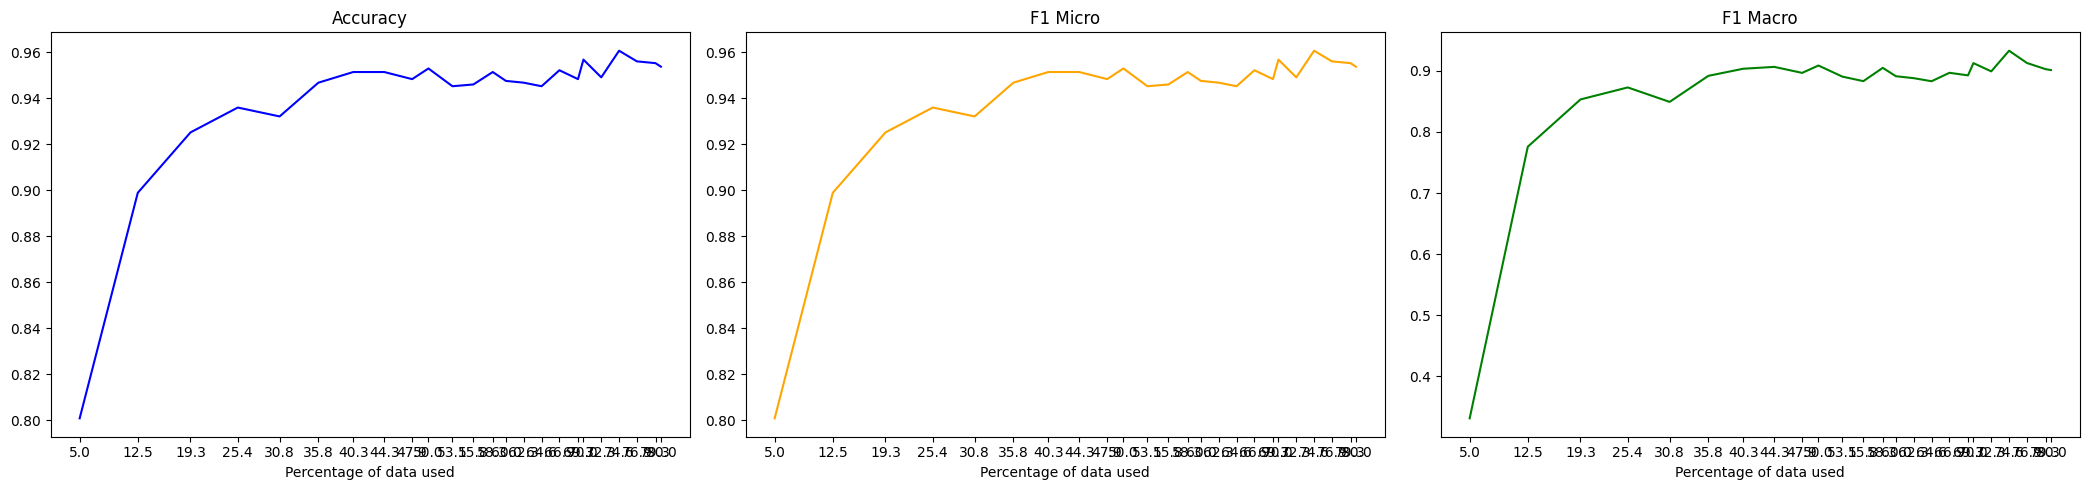

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6791, Accuracy: 0.7746, F1 Micro: 0.8722, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5752, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.512, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4609, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4635, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4127, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3898, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4151, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.8159, Accuracy: 0.3333, F1 Micro: 0.3333, F1 Macro: 0.25
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6264, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5442, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5154, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4038, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3617, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3192, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2942, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3391, Accuracy: 0.66

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6229, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5204, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4987, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.456, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4338, Accuracy: 0.8006, F1 Micro: 0.8877, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.411, Accuracy: 0.8199, F1 Micro: 0.8972, F1 Macro: 0.8957
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.355, Accuracy: 0.8467, F1 Micro: 0.91, F1 Macro: 0.9085
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3133, Accuracy: 0.8571, F1 Micro: 0.915, F1 Macro: 0.9134
Higher F1 achieved, saving model
Epoch 9/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6133, Accuracy: 0.7473, F1 Micro: 0.7473, F1 Macro: 0.4277
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5203, Accuracy: 0.7473, F1 Micro: 0.7473, F1 Macro: 0.4277
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4413, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.6684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3048, Accuracy: 0.8441, F1 Micro: 0.8441, F1 Macro: 0.7789
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2526, Accuracy: 0.8763, F1 Micro: 0.8763, F1 Macro: 0.8417
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1459, Accuracy: 0.8763, F1 Micro: 0.8763, F1 Macro: 0.8491
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.8763, F1 Micro: 0.8763, F1 Macro: 0.8396
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.8656, F1 Micro: 0.8656, F1 Macro: 0.8279
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.8602, F1 Micro: 0.8602, F1 Macro: 0.8265
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5929, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5209, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4726, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4472, Accuracy: 0.8006, F1 Micro: 0.8877, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3857, Accuracy: 0.843, F1 Micro: 0.9085, F1 Macro: 0.9072
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3391, Accuracy: 0.8743, F1 Micro: 0.9253, F1 Macro: 0.9242
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2844, Accuracy: 0.9025, F1 Micro: 0.941, F1 Macro: 0.9394
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2317, Accuracy: 0.9226, F1 Micro: 0.9524, F1 Macro: 0.95
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5903, Accuracy: 0.683, F1 Micro: 0.683, F1 Macro: 0.4058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5251, Accuracy: 0.683, F1 Micro: 0.683, F1 Macro: 0.4058
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3671, Accuracy: 0.875, F1 Micro: 0.875, F1 Macro: 0.8389
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2177, Accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9443
Epoch 5/10, Train Loss: 0.1864, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9361
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.942, F1 Micro: 0.942, F1 Macro: 0.9351
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.933, F1 Micro: 0.933, F1 Macro: 0.9246
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9422
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.939
Epoch 10/10, Train Loss: 0.0617, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5847, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5013, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4559, Accuracy: 0.7991, F1 Micro: 0.887, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4086, Accuracy: 0.8497, F1 Micro: 0.9109, F1 Macro: 0.9091
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3385, Accuracy: 0.8958, F1 Micro: 0.9378, F1 Macro: 0.9365
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2695, Accuracy: 0.9338, F1 Micro: 0.9593, F1 Macro: 0.9579
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2067, Accuracy: 0.9382, F1 Micro: 0.9619, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1684, Accuracy: 0.9405, F1 Micro: 0.9631, F1 Macro: 0.9614
Epoch 9/10, Train Loss: 0.1417, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6018, Accuracy: 0.6953, F1 Micro: 0.6953, F1 Macro: 0.4101
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4179, Accuracy: 0.8672, F1 Micro: 0.8672, F1 Macro: 0.8282
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2545, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9235
Epoch 4/10, Train Loss: 0.1304, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9145
Epoch 5/10, Train Loss: 0.1614, Accuracy: 0.8633, F1 Micro: 0.8633, F1 Macro: 0.8532
Epoch 6/10, Train Loss: 0.1452, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9078
Epoch 7/10, Train Loss: 0.1359, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8923
Epoch 8/10, Train Loss: 0.0895, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8984
Epoch 9/10, Train Loss: 0.1385, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8909
Epoch 10/10, Train Loss: 0.0647, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.9007

Sentiment analysis accuracy: 0.9336, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5594, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5027, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4404, Accuracy: 0.8333, F1 Micro: 0.9039, F1 Macro: 0.9029
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3638, Accuracy: 0.8966, F1 Micro: 0.9382, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.267, Accuracy: 0.9405, F1 Micro: 0.9633, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2073, Accuracy: 0.9472, F1 Micro: 0.9672, F1 Macro: 0.9657
Epoch 7/10, Train Loss: 0.1719, Accuracy: 0.9472, F1 Micro: 0.9671, F1 Macro: 0.9653
Epoch 8/10, Train Loss: 0.1402, Accuracy: 0.9457, F1 Micro: 0.9661, F1 Macro: 0.9641
Epoch 9/10, Train Loss: 0.1125, Accuracy: 0.9472, F1 Micro: 0.9668, F1 Macro: 0.9644
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6137, Accuracy: 0.6652, F1 Micro: 0.6652, F1 Macro: 0.3995
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4007, Accuracy: 0.8755, F1 Micro: 0.8755, F1 Macro: 0.8579
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2262, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9275
Epoch 4/10, Train Loss: 0.188, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.9035
Epoch 5/10, Train Loss: 0.1762, Accuracy: 0.927, F1 Micro: 0.927, F1 Macro: 0.9149
Epoch 6/10, Train Loss: 0.1518, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.9069
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9227, F1 Micro: 0.9227, F1 Macro: 0.9095
Epoch 8/10, Train Loss: 0.1284, Accuracy: 0.9185, F1 Micro: 0.9185, F1 Macro: 0.9109
Epoch 9/10, Train Loss: 0.1347, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9219
Epoch 10/10, Train Loss: 0.0959, Accuracy: 0.9185, F1 Micro: 0.9185, F1 Macro: 0.9118

Sentiment analysis accuracy: 0.9356, F1 Micro: 0.9356,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5556, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4814, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4321, Accuracy: 0.8557, F1 Micro: 0.9157, F1 Macro: 0.9147
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.332, Accuracy: 0.9182, F1 Micro: 0.9503, F1 Macro: 0.9497
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.249, Accuracy: 0.9449, F1 Micro: 0.966, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1891, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1497, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9692
Epoch 8/10, Train Loss: 0.1174, Accuracy: 0.9494, F1 Micro: 0.9683, F1 Macro: 0.9666
Epoch 9/10, Train Loss: 0.1039, Accuracy: 0.9531, F1 Micro: 0.9705, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.544, Accuracy: 0.6816, F1 Micro: 0.6816, F1 Macro: 0.4174
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3703, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8998
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1761, Accuracy: 0.9429, F1 Micro: 0.9429, F1 Macro: 0.9366
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1407, Accuracy: 0.9551, F1 Micro: 0.9551, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.105, Accuracy: 0.9592, F1 Micro: 0.9592, F1 Macro: 0.9527
Epoch 6/10, Train Loss: 0.1071, Accuracy: 0.9469, F1 Micro: 0.9469, F1 Macro: 0.9413
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9306, F1 Micro: 0.9306, F1 Macro: 0.9241
Epoch 8/10, Train Loss: 0.0765, Accuracy: 0.951, F1 Micro: 0.951, F1 Macro: 0.9457
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.9265, F1 Micro: 0.9265, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.049, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5525, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4823, Accuracy: 0.7976, F1 Micro: 0.8864, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3973, Accuracy: 0.8862, F1 Micro: 0.932, F1 Macro: 0.9308
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3002, Accuracy: 0.939, F1 Micro: 0.9625, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2153, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.173, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1439, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9727
Epoch 8/10, Train Loss: 0.1137, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9724
Epoch 9/10, Train Loss: 0.0879, Accuracy: 0.9501, F1 Micro: 0.9686, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5807, Accuracy: 0.7619, F1 Micro: 0.7619, F1 Macro: 0.6465
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3595, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8963
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2043, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9154
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2165, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9421
Epoch 5/10, Train Loss: 0.1744, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9248
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.9131
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.909
Epoch 8/10, Train Loss: 0.1302, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8968
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9411
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0761, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5479, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4719, Accuracy: 0.8036, F1 Micro: 0.889, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3894, Accuracy: 0.907, F1 Micro: 0.944, F1 Macro: 0.9426
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2881, Accuracy: 0.939, F1 Micro: 0.9624, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2102, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9696
Epoch 6/10, Train Loss: 0.1566, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9691
Epoch 7/10, Train Loss: 0.1283, Accuracy: 0.9531, F1 Micro: 0.9706, F1 Macro: 0.9687
Epoch 8/10, Train Loss: 0.1047, Accuracy: 0.9501, F1 Micro: 0.9687, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.087, Accuracy: 0.9561, F1 Micro: 0.9723, F1 Macro: 0.9705
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4882, Accuracy: 0.8717, F1 Micro: 0.8717, F1 Macro: 0.8499
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2512, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9119
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1844, Accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9416
Epoch 4/10, Train Loss: 0.1785, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.9001
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.939
Epoch 6/10, Train Loss: 0.125, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1075, Accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9416
Epoch 8/10, Train Loss: 0.1358, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9275
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9266
Epoch 10/10, Train Loss: 0.061, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9271

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.547, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4596, Accuracy: 0.8311, F1 Micro: 0.9029, F1 Macro: 0.9019
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3551, Accuracy: 0.9263, F1 Micro: 0.9549, F1 Macro: 0.9533
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2484, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1779, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1489, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9715
Epoch 7/10, Train Loss: 0.1102, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9688
Epoch 8/10, Train Loss: 0.0884, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9699
Epoch 9/10, Train Loss: 0.0761, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9701
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5382, Accuracy: 0.8024, F1 Micro: 0.8024, F1 Macro: 0.726
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2797, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9102
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1709, Accuracy: 0.9315, F1 Micro: 0.9315, F1 Macro: 0.9228
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.939
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0946, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.9394
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9355, F1 Micro: 0.9355, F1 Macro: 0.9284
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9358
Epoch 8/10, Train Loss: 0.0563, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9366
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9355, F1 Micro: 0.9355, F1 Macro: 0.9262
Epoch 10/10, Train Loss: 0.0485, Accuracy: 0.9355, F1 Micro: 0.9355, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5512, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.457, Accuracy: 0.8207, F1 Micro: 0.8977, F1 Macro: 0.8962
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3547, Accuracy: 0.9256, F1 Micro: 0.9545, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2555, Accuracy: 0.9501, F1 Micro: 0.9692, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1867, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9722
Epoch 6/10, Train Loss: 0.1458, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1121, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9739
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9731
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5157, Accuracy: 0.8721, F1 Micro: 0.8721, F1 Macro: 0.8417
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2802, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9275
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1728, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9314
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1738, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.947
Epoch 5/10, Train Loss: 0.1598, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9327
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9428
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0928, Accuracy: 0.9574, F1 Micro: 0.9574, F1 Macro: 0.9522
Epoch 8/10, Train Loss: 0.1074, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9111
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9265
Epoch 10/10, Train Loss: 0.0685, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5327, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4623, Accuracy: 0.84, F1 Micro: 0.9075, F1 Macro: 0.9063
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3482, Accuracy: 0.9293, F1 Micro: 0.9563, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2409, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1723, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1331, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1102, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9738
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5238, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2272, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.9131
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1953, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9298
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1729, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9355
Epoch 6/10, Train Loss: 0.1032, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9256
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0943, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.107, Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.9451
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0741, Accuracy: 0.9563, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5406, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4501, Accuracy: 0.8333, F1 Micro: 0.9044, F1 Macro: 0.903
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3214, Accuracy: 0.9338, F1 Micro: 0.9595, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2299, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1639, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1269, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0679, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9741
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5107, Accuracy: 0.8898, F1 Micro: 0.8898, F1 Macro: 0.8723
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2465, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1813, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9388
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9304
Epoch 5/10, Train Loss: 0.1418, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9222
Epoch 6/10, Train Loss: 0.107, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9263
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.9567, F1 Micro: 0.9567, F1 Macro: 0.9512
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9606, F1 Micro: 0.9606, F1 Macro: 0.955
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.9409
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0609, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5496, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4508, Accuracy: 0.8757, F1 Micro: 0.9261, F1 Macro: 0.9246
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.313, Accuracy: 0.9442, F1 Micro: 0.9655, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2194, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0811, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0665, Accuracy: 0.9613, F1 Micro: 0.9754, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5021, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.208, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2121, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9435
Epoch 4/10, Train Loss: 0.142, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9348
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.9579, F1 Micro: 0.9579, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1164, Accuracy: 0.9617, F1 Micro: 0.9617, F1 Macro: 0.9566
Epoch 8/10, Train Loss: 0.1093, Accuracy: 0.9579, F1 Micro: 0.9579, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0919, Accuracy: 0.9617, F1 Micro: 0.9617, F1 Macro: 0.9566
Epoch 10/10, Train Loss: 0.0575, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5368, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.435, Accuracy: 0.878, F1 Micro: 0.9271, F1 Macro: 0.9254
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2987, Accuracy: 0.9457, F1 Micro: 0.9663, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2164, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9741
Epoch 6/10, Train Loss: 0.1097, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0892, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9769
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9734
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9743
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4748, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8998
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2195, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1562, Accuracy: 0.9533, F1 Micro: 0.9533, F1 Macro: 0.9476
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9331
Epoch 5/10, Train Loss: 0.1392, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9293
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9181
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9305
Epoch 8/10, Train Loss: 0.0773, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9309
Epoch 9/10, Train Loss: 0.0836, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9388
Epoch 10/10, Train Loss: 0.0843, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9388

Sentiment analysis accuracy: 0.9533, F1 Micro: 0.95

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.535, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4322, Accuracy: 0.8862, F1 Micro: 0.9323, F1 Macro: 0.931
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2977, Accuracy: 0.9472, F1 Micro: 0.9673, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2045, Accuracy: 0.9576, F1 Micro: 0.9737, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1411, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1172, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9766
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.0724, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5384, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8973
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2801, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9327
Epoch 3/10, Train Loss: 0.1351, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9127
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9401
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9246
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9401
Epoch 7/10, Train Loss: 0.097, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9262
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.921
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.933
Epoch 10/10, Train Loss: 0.0531, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9286

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5268, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4357, Accuracy: 0.9055, F1 Micro: 0.9422, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2845, Accuracy: 0.9516, F1 Micro: 0.9701, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.202, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1455, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1158, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0913, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.0752, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9771
Epoch 9/10, Train Loss: 0.0633, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4901, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2142, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9319
Epoch 3/10, Train Loss: 0.1855, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9096
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9169
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1193, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9379
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9228
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9425
Epoch 9/10, Train Loss: 0.0635, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9351
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0587, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5288, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4234, Accuracy: 0.8906, F1 Micro: 0.9348, F1 Macro: 0.9334
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2882, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2008, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9777
Epoch 5/10, Train Loss: 0.1411, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9736
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 7/10, Train Loss: 0.0832, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9746
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9725
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9751
Epoch 10/10, Train Loss: 0.0495, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769

As

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4992, Accuracy: 0.8852, F1 Micro: 0.8852, F1 Macro: 0.8609
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2557, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9278
Epoch 3/10, Train Loss: 0.1968, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.9036
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1169, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9285
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1015, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9274
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9262, F1 Micro: 0.9262, F1 Macro: 0.9168
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9467, F1 Micro: 0.9467, F1 Macro: 0.9415
Epoch 8/10, Train Loss: 0.0731, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9328
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9325
Epoch 10/10, Train Loss: 0.057, Accuracy: 0.9303, F1 Micro: 0.9303, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5301, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4085, Accuracy: 0.9159, F1 Micro: 0.9486, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2691, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.182, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1023, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9791
Epoch 7/10, Train Loss: 0.0893, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9764
Epoch 8/10, Train Loss: 0.067, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9772
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9784
Epoch 10/10, Train Loss: 0.04

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4777, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.9031
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2365, Accuracy: 0.935, F1 Micro: 0.935, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1841, Accuracy: 0.9431, F1 Micro: 0.9431, F1 Macro: 0.9371
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1272, Accuracy: 0.9431, F1 Micro: 0.9431, F1 Macro: 0.9371
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1305, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9417
Epoch 6/10, Train Loss: 0.0869, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.9338
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.9335
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0759, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9421
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.9553, F1 Micro: 0.9553, F1 Macro: 0.951
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5291, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4243, Accuracy: 0.8891, F1 Micro: 0.933, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2772, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1839, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.9782
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Epoch 10/10, Train Loss: 0.0509, Accuracy: 0.9643, F1 Mi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5101, Accuracy: 0.8917, F1 Micro: 0.8917, F1 Macro: 0.873
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2288, Accuracy: 0.9458, F1 Micro: 0.9458, F1 Macro: 0.9403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1501, Accuracy: 0.9542, F1 Micro: 0.9542, F1 Macro: 0.95
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.925, F1 Micro: 0.925, F1 Macro: 0.9156
Epoch 5/10, Train Loss: 0.0907, Accuracy: 0.925, F1 Micro: 0.925, F1 Macro: 0.9161
Epoch 6/10, Train Loss: 0.1269, Accuracy: 0.9458, F1 Micro: 0.9458, F1 Macro: 0.94
Epoch 7/10, Train Loss: 0.1133, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9456
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.9542, F1 Micro: 0.9542, F1 Macro: 0.9495
Epoch 9/10, Train Loss: 0.056, Accuracy: 0.9458, F1 Micro: 0.9458, F1 Macro: 0.9403
Epoch 10/10, Train Loss: 0.0533, Accuracy: 0.9417, F1 Micro: 0.9417, F1 Macro: 0.9362

Sentiment analysis accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5289, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4117, Accuracy: 0.9152, F1 Micro: 0.9482, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2635, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1739, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9794
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9789
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9736
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9747
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4958, Accuracy: 0.8854, F1 Micro: 0.8854, F1 Macro: 0.877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2183, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9348
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9383
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9565, F1 Micro: 0.9565, F1 Macro: 0.9508
Epoch 5/10, Train Loss: 0.1369, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9265
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9345
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9253
Epoch 8/10, Train Loss: 0.0783, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9372
Epoch 9/10, Train Loss: 0.0662, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9287
Epoch 10/10, Train Loss: 0.0542, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9338

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.527, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.398, Accuracy: 0.9234, F1 Micro: 0.9532, F1 Macro: 0.9517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2441, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1259, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro: 0.9726
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9733
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4766, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2158, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9229
Epoch 3/10, Train Loss: 0.1744, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9237
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9396
Epoch 5/10, Train Loss: 0.1054, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9246
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9273
Epoch 7/10, Train Loss: 0.1084, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9219
Epoch 8/10, Train Loss: 0.0665, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9314
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0659, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0561, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5164, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3973, Accuracy: 0.9241, F1 Micro: 0.9536, F1 Macro: 0.9519
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2502, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.9783
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9774
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4774, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2531, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9189
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1563, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1555, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9267
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9398
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9192
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9297
Epoch 8/10, Train Loss: 0.0695, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9233
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9069
Epoch 10/10, Train Loss: 0.0695, Accuracy: 0.9252, F1 Micro: 0.9252, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5299, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3922, Accuracy: 0.9323, F1 Micro: 0.9585, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.244, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9807
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4739, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8979
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2431, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9301
Epoch 3/10, Train Loss: 0.1763, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.921
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9317
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9297
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9309
Epoch 7/10, Train Loss: 0.0614, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.897
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0753, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9297
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9402
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5299, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4002, Accuracy: 0.9226, F1 Micro: 0.9526, F1 Macro: 0.9512
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2483, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.9702, F1 Micro: 0.9814, F1 Macro: 0.9806
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9777
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9785
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4802, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9363
Epoch 2/10, Train Loss: 0.2307, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9326
Epoch 3/10, Train Loss: 0.1679, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9289
Epoch 4/10, Train Loss: 0.1496, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9062
Epoch 5/10, Train Loss: 0.111, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9148
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9162
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9393
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9201
Epoch 9/10, Train Loss: 0.0522, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9326
Epoch 10/10, Train Loss: 0.0513, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9197

Sentiment analysis accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9393
              precisi

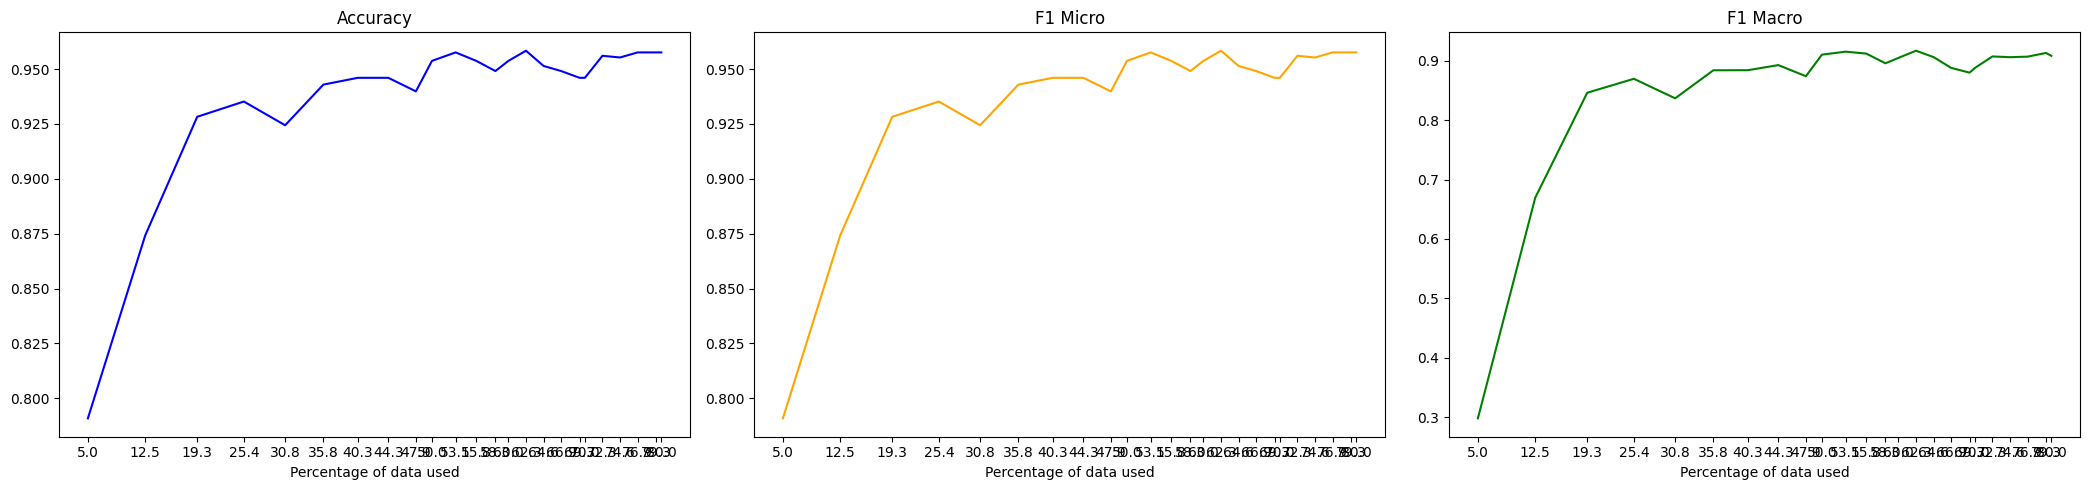

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6456, Accuracy: 0.7865, F1 Micro: 0.8804, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5639, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5346, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5259, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4788, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 6/10, Train Loss: 0.477, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 7/10, Train Loss: 0.4707, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4588, Accuracy: 0.7909, F1 Micro: 0.883, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4215, Accuracy: 0.7932, F1 Micro: 0.8839, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7056, Accuracy: 0.44, F1 Micro: 0.44, F1 Macro: 0.4318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5997, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5241, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5185, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.494, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4806, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4617, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.422, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3873, Accuracy: 0.84, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5981, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5158, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5117, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4848, Accuracy: 0.7969, F1 Micro: 0.8859, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4509, Accuracy: 0.8051, F1 Micro: 0.8894, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4139, Accuracy: 0.8147, F1 Micro: 0.8935, F1 Macro: 0.8915
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3709, Accuracy: 0.84, F1 Micro: 0.9053, F1 Macro: 0.903
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3202, Accuracy: 0.8564, F1 Micro: 0.9151, F1 Macro: 0.9132
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6026, Accuracy: 0.7136, F1 Micro: 0.7136, F1 Macro: 0.4164
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5883, Accuracy: 0.7136, F1 Micro: 0.7136, F1 Macro: 0.4164
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5417, Accuracy: 0.7282, F1 Micro: 0.7282, F1 Macro: 0.4948
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3579, Accuracy: 0.835, F1 Micro: 0.835, F1 Macro: 0.802
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2238, Accuracy: 0.8495, F1 Micro: 0.8495, F1 Macro: 0.8292
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1322, Accuracy: 0.8641, F1 Micro: 0.8641, F1 Macro: 0.8463
Epoch 7/10, Train Loss: 0.0917, Accuracy: 0.8592, F1 Micro: 0.8592, F1 Macro: 0.8447
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.8689, F1 Micro: 0.8689, F1 Macro: 0.8476
Epoch 9/10, Train Loss: 0.1217, Accuracy: 0.8155, F1 Micro: 0.8155, F1 Macro: 0.803
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5867, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.5156, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.4686, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4517, Accuracy: 0.8155, F1 Micro: 0.8947, F1 Macro: 0.8934
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4099, Accuracy: 0.8311, F1 Micro: 0.9028, F1 Macro: 0.9016
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3525, Accuracy: 0.8802, F1 Micro: 0.928, F1 Macro: 0.9263
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3002, Accuracy: 0.9048, F1 Micro: 0.942, F1 Macro: 0.9405
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.245, Accuracy: 0.9167, F1 Micro: 0.9488, F1 Macro: 0.9469
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2086, Accuracy: 0.9338, F1 Micro: 0.9592, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6486, Accuracy: 0.6814, F1 Micro: 0.6814, F1 Macro: 0.4053
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5304, Accuracy: 0.6991, F1 Micro: 0.6991, F1 Macro: 0.4732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4413, Accuracy: 0.8894, F1 Micro: 0.8894, F1 Macro: 0.8712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2573, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1655, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1735, Accuracy: 0.9159, F1 Micro: 0.9159, F1 Macro: 0.9049
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1431, Accuracy: 0.9159, F1 Micro: 0.9159, F1 Macro: 0.9073
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1047, Accuracy: 0.9159, F1 Micro: 0.9159, F1 Macro: 0.9073
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5769, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.5068, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4727, Accuracy: 0.7961, F1 Micro: 0.885, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4229, Accuracy: 0.8266, F1 Micro: 0.9003, F1 Macro: 0.8988
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3563, Accuracy: 0.8795, F1 Micro: 0.9273, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2852, Accuracy: 0.904, F1 Micro: 0.941, F1 Macro: 0.9383
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2257, Accuracy: 0.9226, F1 Micro: 0.9517, F1 Macro: 0.9477
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.181, Accuracy: 0.9457, F1 Micro: 0.9664, F1 Macro: 0.9649
Epoch 9/10, Train Loss: 0.1492, Accuracy: 0.9449, F1 Micro: 0.9658, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.603, Accuracy: 0.6756, F1 Micro: 0.6756, F1 Macro: 0.4032
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4655, Accuracy: 0.8844, F1 Micro: 0.8844, F1 Macro: 0.8672
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2822, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.9013
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1873, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.9088
Epoch 5/10, Train Loss: 0.1717, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1146, Accuracy: 0.9378, F1 Micro: 0.9378, F1 Macro: 0.9309
Epoch 7/10, Train Loss: 0.144, Accuracy: 0.88, F1 Micro: 0.88, F1 Macro: 0.8721
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1419, Accuracy: 0.9556, F1 Micro: 0.9556, F1 Macro: 0.9497
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.8533, F1 Micro: 0.8533, F1 Macro: 0.8463
Higher F1 achieved, saving model
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5594, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.5047, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4525, Accuracy: 0.8155, F1 Micro: 0.894, F1 Macro: 0.8918
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3738, Accuracy: 0.8772, F1 Micro: 0.9262, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2892, Accuracy: 0.9129, F1 Micro: 0.9464, F1 Macro: 0.9435
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2309, Accuracy: 0.9368, F1 Micro: 0.9611, F1 Macro: 0.9596
Epoch 7/10, Train Loss: 0.1866, Accuracy: 0.936, F1 Micro: 0.9602, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1399, Accuracy: 0.9464, F1 Micro: 0.9664, F1 Macro: 0.964
Epoch 9/10, Train Loss: 0.1214, Accuracy: 0.942, F1 Micro: 0.9634, F1 Macro: 0.96
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5796, Accuracy: 0.6892, F1 Micro: 0.6892, F1 Macro: 0.408
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4027, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8929
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2251, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9284
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.919
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9358
Epoch 6/10, Train Loss: 0.151, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.92
Epoch 7/10, Train Loss: 0.117, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9319
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1197, Accuracy: 0.9602, F1 Micro: 0.9602, F1 Macro: 0.9541
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.946
Epoch 10/10, Train Loss: 0.0994, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.549, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 2/10, Train Loss: 0.4821, Accuracy: 0.7879, F1 Micro: 0.8805, F1 Macro: 0.8783
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4178, Accuracy: 0.8445, F1 Micro: 0.9083, F1 Macro: 0.9064
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3371, Accuracy: 0.9077, F1 Micro: 0.9428, F1 Macro: 0.9401
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2423, Accuracy: 0.9368, F1 Micro: 0.9606, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1774, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1438, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1147, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9722
Epoch 9/10, Train Loss: 0.0897, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5702, Accuracy: 0.7165, F1 Micro: 0.7165, F1 Macro: 0.5139
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3425, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9131
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1889, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9265
Epoch 4/10, Train Loss: 0.1472, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9181
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.942
Epoch 6/10, Train Loss: 0.1625, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9366
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9297
Epoch 8/10, Train Loss: 0.1039, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9327
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9237
Epoch 10/10, Train Loss: 0.0647, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9331

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.557, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4751, Accuracy: 0.7954, F1 Micro: 0.8842, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4162, Accuracy: 0.8594, F1 Micro: 0.9158, F1 Macro: 0.9122
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3158, Accuracy: 0.9219, F1 Micro: 0.952, F1 Macro: 0.9499
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2252, Accuracy: 0.9435, F1 Micro: 0.9647, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1728, Accuracy: 0.9516, F1 Micro: 0.9697, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1382, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.109, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0876, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5524, Accuracy: 0.8409, F1 Micro: 0.8409, F1 Macro: 0.794
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2735, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1627, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9245
Epoch 4/10, Train Loss: 0.1336, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9168
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1011, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9285
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9285
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9393
Epoch 9/10, Train Loss: 0.0613, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9145
Epoch 10/10, Train Loss: 0.043, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5511, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4691, Accuracy: 0.7946, F1 Micro: 0.883, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4045, Accuracy: 0.8534, F1 Micro: 0.9122, F1 Macro: 0.9101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.302, Accuracy: 0.9211, F1 Micro: 0.951, F1 Macro: 0.9486
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2203, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1631, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1307, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0968, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.084, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5556, Accuracy: 0.7733, F1 Micro: 0.7733, F1 Macro: 0.6637
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3026, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9389
Epoch 3/10, Train Loss: 0.1824, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.9279
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1416, Accuracy: 0.9514, F1 Micro: 0.9514, F1 Macro: 0.9449
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.929
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0754, Accuracy: 0.9595, F1 Micro: 0.9595, F1 Macro: 0.9544
Epoch 7/10, Train Loss: 0.1151, Accuracy: 0.9514, F1 Micro: 0.9514, F1 Macro: 0.9456
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.929
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9419
Epoch 10/10, Train Loss: 0.0571, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9408

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5455, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4718, Accuracy: 0.8132, F1 Micro: 0.8924, F1 Macro: 0.8899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3664, Accuracy: 0.904, F1 Micro: 0.9418, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2561, Accuracy: 0.9442, F1 Micro: 0.9653, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1846, Accuracy: 0.9501, F1 Micro: 0.9687, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1405, Accuracy: 0.9546, F1 Micro: 0.9714, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9725
Epoch 8/10, Train Loss: 0.0895, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9723
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5576, Accuracy: 0.8246, F1 Micro: 0.8246, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3133, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9315
Epoch 3/10, Train Loss: 0.2248, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9279
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.165, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9315
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9552, F1 Micro: 0.9552, F1 Macro: 0.9483
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9331
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9389
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9371
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9352
Epoch 10/10, Train Loss: 0.0584, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9256

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5404, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4761, Accuracy: 0.8021, F1 Micro: 0.8879, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3773, Accuracy: 0.8988, F1 Micro: 0.9378, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2717, Accuracy: 0.9412, F1 Micro: 0.9633, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1961, Accuracy: 0.9472, F1 Micro: 0.9667, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1501, Accuracy: 0.9554, F1 Micro: 0.9718, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1094, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.548, Accuracy: 0.8677, F1 Micro: 0.8677, F1 Macro: 0.8387
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2719, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9316
Epoch 3/10, Train Loss: 0.1859, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8924
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8924
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1305, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9301
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.944
Epoch 8/10, Train Loss: 0.0871, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9316
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9131
Epoch 10/10, Train Loss: 0.0608, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9319

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5464, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4653, Accuracy: 0.8214, F1 Micro: 0.8966, F1 Macro: 0.8947
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3613, Accuracy: 0.9167, F1 Micro: 0.949, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2425, Accuracy: 0.9375, F1 Micro: 0.9611, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1766, Accuracy: 0.9457, F1 Micro: 0.9657, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1398, Accuracy: 0.9501, F1 Micro: 0.9685, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1038, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0877, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9728
Epoch 9/10, Train Loss: 0.0664, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5163, Accuracy: 0.8842, F1 Micro: 0.8842, F1 Macro: 0.8702
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2333, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9394
Epoch 3/10, Train Loss: 0.1714, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9349
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9575, F1 Micro: 0.9575, F1 Macro: 0.9508
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9193
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9234
Epoch 7/10, Train Loss: 0.1235, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9439
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.9614, F1 Micro: 0.9614, F1 Macro: 0.9557
Epoch 9/10, Train Loss: 0.0726, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9274
Epoch 10/10, Train Loss: 0.0419, Accuracy: 0.9537, F1 Micro: 0.9537, F1 Macro: 0.9465

Sentiment analys

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5417, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4592, Accuracy: 0.8356, F1 Micro: 0.9042, F1 Macro: 0.9022
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3326, Accuracy: 0.9226, F1 Micro: 0.9518, F1 Macro: 0.949
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2224, Accuracy: 0.9449, F1 Micro: 0.9656, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.175, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1298, Accuracy: 0.965, F1 Micro: 0.9782, F1 Macro: 0.9772
Epoch 7/10, Train Loss: 0.106, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9713
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.067, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9738
Epoch 10/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5403, Accuracy: 0.8484, F1 Micro: 0.8484, F1 Macro: 0.8139
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3137, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9128
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.173, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9455
Epoch 4/10, Train Loss: 0.0969, Accuracy: 0.9426, F1 Micro: 0.9426, F1 Macro: 0.9378
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.9426, F1 Micro: 0.9426, F1 Macro: 0.9345
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9426, F1 Micro: 0.9426, F1 Macro: 0.9381
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1097, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9467
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9467, F1 Micro: 0.9467, F1 Macro: 0.9424
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.9467, F1 Micro: 0.9467, F1 Macro: 0.9424
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0468, Accuracy: 0.9508, F1 Micro: 0.9508, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5332, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4605, Accuracy: 0.8356, F1 Micro: 0.903, F1 Macro: 0.9008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3392, Accuracy: 0.9263, F1 Micro: 0.9541, F1 Macro: 0.9515
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2225, Accuracy: 0.9509, F1 Micro: 0.9695, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1186, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.0928, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5357, Accuracy: 0.794, F1 Micro: 0.794, F1 Macro: 0.7061
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2693, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9254
Epoch 3/10, Train Loss: 0.1884, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9218
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9376
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9261
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9109
Epoch 7/10, Train Loss: 0.0817, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.925
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9265
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.925
Epoch 10/10, Train Loss: 0.04, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9148

Sentiment analysis accuracy: 0.9438, F1 Micro: 0.9438, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5299, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4577, Accuracy: 0.8348, F1 Micro: 0.9037, F1 Macro: 0.902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3156, Accuracy: 0.9345, F1 Micro: 0.9596, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2078, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1539, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9738
Epoch 6/10, Train Loss: 0.1138, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.974
Epoch 9/10, Train Loss: 0.0614, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.974
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4954, Accuracy: 0.8943, F1 Micro: 0.8943, F1 Macro: 0.8772
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.264, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9319
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1486, Accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9439
Epoch 4/10, Train Loss: 0.1506, Accuracy: 0.883, F1 Micro: 0.883, F1 Macro: 0.8742
Epoch 5/10, Train Loss: 0.1807, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.9045
Epoch 6/10, Train Loss: 0.1155, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.9011
Epoch 7/10, Train Loss: 0.1087, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9279
Epoch 8/10, Train Loss: 0.103, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9159
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9163
Epoch 10/10, Train Loss: 0.0634, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.936

Sentiment analysis accuracy: 0.9509, F1 Micro: 0.9509,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5275, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4406, Accuracy: 0.8504, F1 Micro: 0.912, F1 Macro: 0.9102
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.297, Accuracy: 0.9338, F1 Micro: 0.9592, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2058, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.974
Epoch 5/10, Train Loss: 0.1478, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9717
Epoch 6/10, Train Loss: 0.1078, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0882, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9606, F1 Micro: 0.9749, F1 Macro: 0.9728
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.528, Accuracy: 0.8881, F1 Micro: 0.8881, F1 Macro: 0.8682
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2726, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9331
Epoch 3/10, Train Loss: 0.1682, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9291
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1149, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9323
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9229
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9287
Epoch 7/10, Train Loss: 0.0965, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.927
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9189
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.9103
Epoch 10/10, Train Loss: 0.059, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9212

Sentiment analysis accuracy: 0.9403, F1 Micro: 0.940

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5306, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4404, Accuracy: 0.8705, F1 Micro: 0.923, F1 Macro: 0.9214
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3121, Accuracy: 0.9375, F1 Micro: 0.9615, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2175, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1488, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9768
Epoch 6/10, Train Loss: 0.1172, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.9568, F1 Micro: 0.9727, F1 Macro: 0.9705
Epoch 8/10, Train Loss: 0.074, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5049, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.266, Accuracy: 0.9312, F1 Micro: 0.9312, F1 Macro: 0.9223
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1509, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9383
Epoch 4/10, Train Loss: 0.1591, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9197
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.942, F1 Micro: 0.942, F1 Macro: 0.9329
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.9126
Epoch 7/10, Train Loss: 0.1013, Accuracy: 0.9312, F1 Micro: 0.9312, F1 Macro: 0.9205
Epoch 8/10, Train Loss: 0.0942, Accuracy: 0.9312, F1 Micro: 0.9312, F1 Macro: 0.9223
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9088
Epoch 10/10, Train Loss: 0.0492, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9088

Sentiment analysis accuracy: 0.9457, F1 Micro: 0.945

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5214, Accuracy: 0.7909, F1 Micro: 0.883, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4323, Accuracy: 0.8586, F1 Micro: 0.9154, F1 Macro: 0.9128
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2906, Accuracy: 0.9435, F1 Micro: 0.9649, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1948, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9753
Epoch 6/10, Train Loss: 0.1051, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9721
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0673, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0564, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4778, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2436, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9249
Epoch 3/10, Train Loss: 0.1787, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1357, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9293
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.9135
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.9122
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9173
Epoch 10/10, Train Loss: 0.0675, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5273, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.422, Accuracy: 0.8854, F1 Micro: 0.9309, F1 Macro: 0.9288
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2771, Accuracy: 0.9487, F1 Micro: 0.968, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1343, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9798
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4698, Accuracy: 0.8817, F1 Micro: 0.8817, F1 Macro: 0.8729
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2101, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.929
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.9018
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.141, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1341, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9404
Epoch 6/10, Train Loss: 0.1137, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9279
Epoch 7/10, Train Loss: 0.0612, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9242
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9283
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.917
Epoch 10/10, Train Loss: 0.0533, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9242

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5185, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4299, Accuracy: 0.8981, F1 Micro: 0.9378, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2746, Accuracy: 0.9509, F1 Micro: 0.9693, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1735, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9748
Epoch 6/10, Train Loss: 0.1065, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0841, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0554, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.498, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2448, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1798, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.936
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9287
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9239
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9257
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0857, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.936
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9199
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9057
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0622, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5224, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4287, Accuracy: 0.8973, F1 Micro: 0.9383, F1 Macro: 0.9364
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2715, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1806, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4691, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9119
Epoch 2/10, Train Loss: 0.225, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1589, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9442
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1445, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9468
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9341
Epoch 6/10, Train Loss: 0.1089, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9384
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9281
Epoch 8/10, Train Loss: 0.1003, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9352
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.9035
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.074, Accuracy: 0.9648, F1 Micro: 0.9648, F1 Macro: 0.9603

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.521, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4194, Accuracy: 0.8943, F1 Micro: 0.9344, F1 Macro: 0.93
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2607, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1687, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9799
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4653, Accuracy: 0.8846, F1 Micro: 0.8846, F1 Macro: 0.8781
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2349, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9092
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1561, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9109
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1396, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9368
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9452
Epoch 7/10, Train Loss: 0.0879, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9313
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9207
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.925
Epoch 10/10, Train Loss: 0.0554, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.531, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4167, Accuracy: 0.8958, F1 Micro: 0.9363, F1 Macro: 0.9332
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.267, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1787, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Epoch 7/10, Train Loss: 0.077, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.9695, F1 Micro: 0.9807, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4772, Accuracy: 0.9301, F1 Micro: 0.9301, F1 Macro: 0.919
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2044, Accuracy: 0.9301, F1 Micro: 0.9301, F1 Macro: 0.9179
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1644, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9379
Epoch 4/10, Train Loss: 0.1485, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9266
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1148, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9459
Epoch 6/10, Train Loss: 0.1097, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.911
Epoch 7/10, Train Loss: 0.0857, Accuracy: 0.9265, F1 Micro: 0.9265, F1 Macro: 0.9187
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0755, Accuracy: 0.9559, F1 Micro: 0.9559, F1 Macro: 0.9493
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.9596, F1 Micro: 0.9596, F1 Macro: 0.9531
Epoch 10/10, Train Loss: 0.0683, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5202, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4065, Accuracy: 0.9196, F1 Micro: 0.9506, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2473, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9749
Epoch 5/10, Train Loss: 0.1286, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9725
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9796
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4584, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9284
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2376, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1935, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9416
Epoch 4/10, Train Loss: 0.1203, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9376
Epoch 5/10, Train Loss: 0.1068, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9336
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9292
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9129
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9139
Epoch 9/10, Train Loss: 0.0617, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9324
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.049, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9412

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5143, Accuracy: 0.7917, F1 Micro: 0.8833, F1 Macro: 0.8818
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4086, Accuracy: 0.9115, F1 Micro: 0.9456, F1 Macro: 0.9431
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2639, Accuracy: 0.9442, F1 Micro: 0.9649, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1747, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0903, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9773
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9598, F1 Micro: 0.9745, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4918, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8941
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2279, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9142
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1716, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.926
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1489, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9321
Epoch 5/10, Train Loss: 0.1145, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.913
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1242, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9409
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9402
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9308
Epoch 9/10, Train Loss: 0.0886, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 

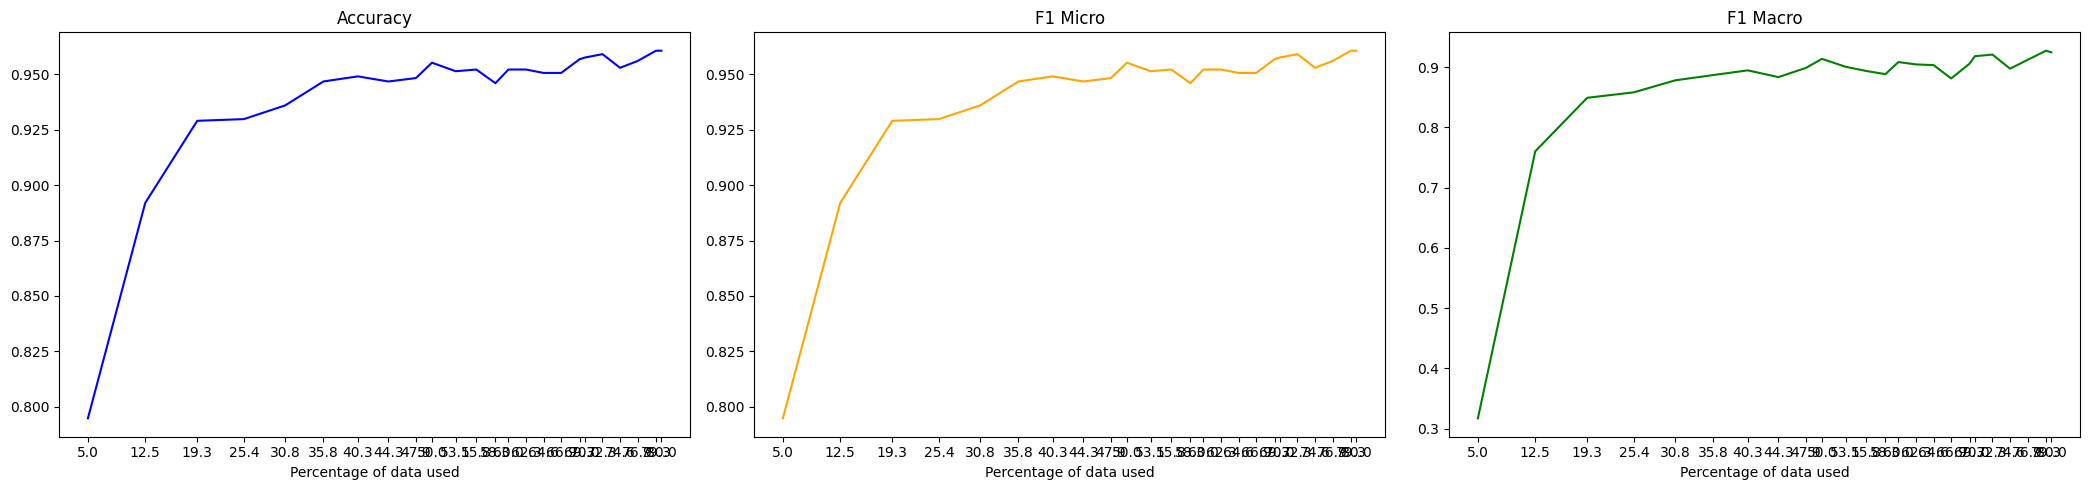

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6298, Accuracy: 0.7522, F1 Micro: 0.854, F1 Macro: 0.8362
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5654, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5262, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4783, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4582, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4326, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4132, Accuracy: 0.7924, F1 Micro: 0.8837, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4395, Accuracy: 0.7939, F1 Micro: 0.8842, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7142, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5719, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6151, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5677, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5123, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5138, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4932, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3579, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6104, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4983, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4891, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4497, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4308, Accuracy: 0.8043, F1 Micro: 0.8894, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4009, Accuracy: 0.814, F1 Micro: 0.8942, F1 Macro: 0.8928
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.36, Accuracy: 0.8341, F1 Micro: 0.9039, F1 Macro: 0.9031
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3365, Accuracy: 0.8415, F1 Micro: 0.9071, F1 Macro: 0.9056
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.67, Accuracy: 0.7445, F1 Micro: 0.7445, F1 Macro: 0.4268
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6039, Accuracy: 0.7445, F1 Micro: 0.7445, F1 Macro: 0.4268
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4801, Accuracy: 0.8102, F1 Micro: 0.8102, F1 Macro: 0.648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.417, Accuracy: 0.8905, F1 Micro: 0.8905, F1 Macro: 0.8487
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2942, Accuracy: 0.8905, F1 Micro: 0.8905, F1 Macro: 0.8547
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1387, Accuracy: 0.927, F1 Micro: 0.927, F1 Macro: 0.9104
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9246
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.067, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9246
Epoch 9/10, Train Loss: 0.0205, Accuracy: 0.9197, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.595, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5103, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4914, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4547, Accuracy: 0.8051, F1 Micro: 0.8898, F1 Macro: 0.8883
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4016, Accuracy: 0.8326, F1 Micro: 0.9037, F1 Macro: 0.9029
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3579, Accuracy: 0.875, F1 Micro: 0.9255, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2769, Accuracy: 0.9077, F1 Micro: 0.9442, F1 Macro: 0.9428
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2324, Accuracy: 0.9159, F1 Micro: 0.9479, F1 Macro: 0.9455
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6453, Accuracy: 0.6727, F1 Micro: 0.6727, F1 Macro: 0.4022
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5693, Accuracy: 0.6727, F1 Micro: 0.6727, F1 Macro: 0.4022
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4591, Accuracy: 0.8818, F1 Micro: 0.8818, F1 Macro: 0.8581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2478, Accuracy: 0.9227, F1 Micro: 0.9227, F1 Macro: 0.9158
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1853, Accuracy: 0.9364, F1 Micro: 0.9364, F1 Macro: 0.9287
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1651, Accuracy: 0.9364, F1 Micro: 0.9364, F1 Macro: 0.9305
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9401
Epoch 9/10, Train Loss: 0.0975, Accuracy: 0.9318, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5774, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5142, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4784, Accuracy: 0.8013, F1 Micro: 0.8882, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4134, Accuracy: 0.8408, F1 Micro: 0.9078, F1 Macro: 0.9071
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3496, Accuracy: 0.9018, F1 Micro: 0.9411, F1 Macro: 0.9401
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2642, Accuracy: 0.9338, F1 Micro: 0.9592, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.203, Accuracy: 0.9442, F1 Micro: 0.9655, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1729, Accuracy: 0.9449, F1 Micro: 0.9658, F1 Macro: 0.9645
Epoch 9/10, Train Loss: 0.1306, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6, Accuracy: 0.684, F1 Micro: 0.684, F1 Macro: 0.4062
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4019, Accuracy: 0.8658, F1 Micro: 0.8658, F1 Macro: 0.8418
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2463, Accuracy: 0.9437, F1 Micro: 0.9437, F1 Macro: 0.9373
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1174, Accuracy: 0.9567, F1 Micro: 0.9567, F1 Macro: 0.951
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9437, F1 Micro: 0.9437, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0581, Accuracy: 0.961, F1 Micro: 0.961, F1 Macro: 0.9557
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9481, F1 Micro: 0.9481, F1 Macro: 0.9416
Epoch 8/10, Train Loss: 0.0442, Accuracy: 0.9437, F1 Micro: 0.9437, F1 Macro: 0.9365
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.9459
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5611, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4914, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4449, Accuracy: 0.8266, F1 Micro: 0.9008, F1 Macro: 0.9
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3734, Accuracy: 0.8936, F1 Micro: 0.9365, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2936, Accuracy: 0.9323, F1 Micro: 0.9583, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2087, Accuracy: 0.9479, F1 Micro: 0.9675, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1644, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9695
Epoch 8/10, Train Loss: 0.1283, Accuracy: 0.9494, F1 Micro: 0.9684, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1109, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5666, Accuracy: 0.6787, F1 Micro: 0.6787, F1 Macro: 0.4043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3759, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9048
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.166, Accuracy: 0.9317, F1 Micro: 0.9317, F1 Macro: 0.9215
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.8876, F1 Micro: 0.8876, F1 Macro: 0.8793
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1071, Accuracy: 0.9317, F1 Micro: 0.9317, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0695, Accuracy: 0.9598, F1 Micro: 0.9598, F1 Macro: 0.9543
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8997
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.9598, F1 Micro: 0.9598, F1 Macro: 0.9543
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9286
Epoch 10/10, Train Loss: 0.0376, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5502, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4702, Accuracy: 0.8036, F1 Micro: 0.8893, F1 Macro: 0.8878
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4076, Accuracy: 0.8557, F1 Micro: 0.9157, F1 Macro: 0.9148
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3228, Accuracy: 0.9249, F1 Micro: 0.9542, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2444, Accuracy: 0.9442, F1 Micro: 0.9656, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1779, Accuracy: 0.9464, F1 Micro: 0.9665, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1405, Accuracy: 0.9509, F1 Micro: 0.9693, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1031, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.577, Accuracy: 0.6825, F1 Micro: 0.6825, F1 Macro: 0.4057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.343, Accuracy: 0.8968, F1 Micro: 0.8968, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1376, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1137, Accuracy: 0.9563, F1 Micro: 0.9563, F1 Macro: 0.9495
Epoch 5/10, Train Loss: 0.1425, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.9045
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.9458
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.9563, F1 Micro: 0.9563, F1 Macro: 0.9504
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9379
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9563, F1 Micro: 0.9563, F1 Macro: 0.9507
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.555, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4784, Accuracy: 0.7999, F1 Micro: 0.8875, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4106, Accuracy: 0.8728, F1 Micro: 0.925, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3221, Accuracy: 0.9315, F1 Micro: 0.958, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.216, Accuracy: 0.9479, F1 Micro: 0.9675, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1686, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9704
Epoch 7/10, Train Loss: 0.133, Accuracy: 0.9524, F1 Micro: 0.9702, F1 Macro: 0.9689
Epoch 8/10, Train Loss: 0.1038, Accuracy: 0.9531, F1 Micro: 0.9705, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0828, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6093, Accuracy: 0.6897, F1 Micro: 0.6897, F1 Macro: 0.4198
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3384, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9067
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1705, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9015
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1344, Accuracy: 0.9579, F1 Micro: 0.9579, F1 Macro: 0.9506
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9369
Epoch 7/10, Train Loss: 0.1183, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8953
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.954, F1 Micro: 0.954, F1 Macro: 0.9467
Epoch 9/10, Train Loss: 0.0783, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9158
Epoch 10/10, Train Loss: 0.0568, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5473, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4938, Accuracy: 0.8051, F1 Micro: 0.8899, F1 Macro: 0.8887
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3874, Accuracy: 0.8832, F1 Micro: 0.9307, F1 Macro: 0.9299
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2883, Accuracy: 0.942, F1 Micro: 0.9641, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2089, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.155, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1219, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.0866, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5412, Accuracy: 0.823, F1 Micro: 0.823, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.9465, F1 Micro: 0.9465, F1 Macro: 0.9388
Epoch 3/10, Train Loss: 0.1421, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9189
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.963, F1 Micro: 0.963, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1495, Accuracy: 0.9671, F1 Micro: 0.9671, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1127, Accuracy: 0.9671, F1 Micro: 0.9671, F1 Macro: 0.9632
Epoch 7/10, Train Loss: 0.1037, Accuracy: 0.963, F1 Micro: 0.963, F1 Macro: 0.9577
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9671, F1 Micro: 0.9671, F1 Macro: 0.963
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.963, F1 Micro: 0.963, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 10/10, Train

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5468, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.469, Accuracy: 0.808, F1 Micro: 0.8916, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3781, Accuracy: 0.9234, F1 Micro: 0.9533, F1 Macro: 0.9518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2531, Accuracy: 0.9524, F1 Micro: 0.9706, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1765, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0987, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.0692, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5267, Accuracy: 0.6783, F1 Micro: 0.6783, F1 Macro: 0.4042
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2606, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9351
Epoch 3/10, Train Loss: 0.1631, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9265
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9161
Epoch 5/10, Train Loss: 0.0997, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9155
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1259, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9438
Epoch 9/10, Train Loss: 0.0834, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9323
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0511, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5495, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4808, Accuracy: 0.8125, F1 Micro: 0.8938, F1 Macro: 0.8924
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3665, Accuracy: 0.9278, F1 Micro: 0.956, F1 Macro: 0.9547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2535, Accuracy: 0.9442, F1 Micro: 0.9653, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1849, Accuracy: 0.9524, F1 Micro: 0.9702, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9767
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5382, Accuracy: 0.8167, F1 Micro: 0.8167, F1 Macro: 0.7659
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2522, Accuracy: 0.9243, F1 Micro: 0.9243, F1 Macro: 0.9183
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.142, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1473, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1143, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9472
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9602, F1 Micro: 0.9602, F1 Macro: 0.9558
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9266
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9307
Epoch 9/10, Train Loss: 0.0842, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9307
Epoch 10/10, Train Loss: 0.036, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5407, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4682, Accuracy: 0.8341, F1 Micro: 0.9044, F1 Macro: 0.9037
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3513, Accuracy: 0.9368, F1 Micro: 0.9611, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2429, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.168, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1308, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0994, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 9/10, Trai

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4524, Accuracy: 0.8876, F1 Micro: 0.8876, F1 Macro: 0.8653
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2388, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9159
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1721, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9236
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1475, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.9477
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.948
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.939
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9358
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.9467
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9302
Epoch 10/10, Train Loss: 0.0625, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5338, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4504, Accuracy: 0.8251, F1 Micro: 0.9002, F1 Macro: 0.8991
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.332, Accuracy: 0.936, F1 Micro: 0.9605, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2255, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1604, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1205, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0673, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5661, Accuracy: 0.7047, F1 Micro: 0.7047, F1 Macro: 0.498
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3013, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1765, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.942
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1431, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.943
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.9413
Epoch 6/10, Train Loss: 0.0856, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9366
Epoch 7/10, Train Loss: 0.109, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9377
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.9063
Epoch 9/10, Train Loss: 0.0622, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9391
Epoch 10/10, Train Loss: 0.0546, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5334, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4571, Accuracy: 0.8467, F1 Micro: 0.9109, F1 Macro: 0.9102
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3273, Accuracy: 0.9397, F1 Micro: 0.9628, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2115, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1236, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.0918, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0771, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5036, Accuracy: 0.8833, F1 Micro: 0.8833, F1 Macro: 0.8657
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2115, Accuracy: 0.9533, F1 Micro: 0.9533, F1 Macro: 0.9466
Epoch 3/10, Train Loss: 0.1334, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.943
Epoch 4/10, Train Loss: 0.1296, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.965, F1 Micro: 0.965, F1 Macro: 0.9606
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9354
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9312
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9231
Epoch 9/10, Train Loss: 0.0612, Accuracy: 0.9533, F1 Micro: 0.9533, F1 Macro: 0.9469
Epoch 10/10, Train Loss: 0.0557, Accuracy: 0.9572, F1 Micro: 0.9572, F1 Macro: 0.9515

Sentiment analysis accuracy: 0.965, F1 Micro: 0.965, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5389, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4488, Accuracy: 0.8601, F1 Micro: 0.9176, F1 Macro: 0.917
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.312, Accuracy: 0.9464, F1 Micro: 0.9669, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2055, Accuracy: 0.9591, F1 Micro: 0.9746, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1104, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9773
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9765
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9766
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5297, Accuracy: 0.884, F1 Micro: 0.884, F1 Macro: 0.8711
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2345, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9416
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1605, Accuracy: 0.956, F1 Micro: 0.956, F1 Macro: 0.9508
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.9004
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.956, F1 Micro: 0.956, F1 Macro: 0.9508
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0746, Accuracy: 0.964, F1 Micro: 0.964, F1 Macro: 0.9595
Epoch 7/10, Train Loss: 0.0611, Accuracy: 0.96, F1 Micro: 0.96, F1 Macro: 0.9546
Epoch 8/10, Train Loss: 0.0771, Accuracy: 0.96, F1 Micro: 0.96, F1 Macro: 0.9534
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.96, F1 Micro: 0.96, F1 Macro: 0.9537
Epoch 10/10, Train Loss: 0.0583, Accuracy: 0.96, F1 Micro: 0.96, F1 Macro: 0.9549

Sentiment a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5391, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4255, Accuracy: 0.8839, F1 Micro: 0.931, F1 Macro: 0.9305
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2846, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1883, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1374, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9795
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5312, Accuracy: 0.874, F1 Micro: 0.874, F1 Macro: 0.8614
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.236, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9312
Epoch 3/10, Train Loss: 0.1727, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9242
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9206
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9404
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9286
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9246
Epoch 9/10, Train Loss: 0.068, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0521, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5345, Accuracy: 0.7961, F1 Micro: 0.8833, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4476, Accuracy: 0.8646, F1 Micro: 0.9204, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3008, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1996, Accuracy: 0.9494, F1 Micro: 0.9682, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1126, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0875, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Epoch 8/10, Train Loss: 0.0714, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5114, Accuracy: 0.8906, F1 Micro: 0.8906, F1 Macro: 0.8732
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2638, Accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9457
Epoch 3/10, Train Loss: 0.1658, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9211
Epoch 4/10, Train Loss: 0.1343, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9371
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9266
Epoch 6/10, Train Loss: 0.1075, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9408
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9176
Epoch 8/10, Train Loss: 0.087, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9102
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9374
Epoch 10/10, Train Loss: 0.0393, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9298

Sentiment analysis accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9457
             

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5251, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4296, Accuracy: 0.8884, F1 Micro: 0.9336, F1 Macro: 0.9329
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2838, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.186, Accuracy: 0.9531, F1 Micro: 0.9706, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1331, Accuracy: 0.9576, F1 Micro: 0.9732, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0566, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.504, Accuracy: 0.8927, F1 Micro: 0.8927, F1 Macro: 0.8747
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2277, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9322
Epoch 3/10, Train Loss: 0.1669, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9165
Epoch 4/10, Train Loss: 0.1289, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9273
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9393
Epoch 6/10, Train Loss: 0.0799, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9318
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9362
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9133
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.073, Accuracy: 0.9579, F1 Micro: 0.9579, F1 Macro: 0.9527
Epoch 10/10, Train Loss: 0.0545, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8968

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.524, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4257, Accuracy: 0.9018, F1 Micro: 0.9411, F1 Macro: 0.9399
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2728, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9786
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9795
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5464, Accuracy: 0.8854, F1 Micro: 0.8854, F1 Macro: 0.8651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.255, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9166
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1871, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9183
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9183
Epoch 5/10, Train Loss: 0.1459, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.9029
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1075, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9231
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9109
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0852, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9426
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5282, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4281, Accuracy: 0.8966, F1 Micro: 0.9379, F1 Macro: 0.9368
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2734, Accuracy: 0.9479, F1 Micro: 0.9674, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.188, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1018, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4611, Accuracy: 0.9182, F1 Micro: 0.9182, F1 Macro: 0.9096
Epoch 2/10, Train Loss: 0.185, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.926
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1161, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9357
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9336
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9369
Epoch 7/10, Train Loss: 0.084, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9213
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9249
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.9066
Epoch 10/10, Train Loss: 0.0541, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9324

Sentiment analysis accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.532, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4254, Accuracy: 0.8876, F1 Micro: 0.9325, F1 Macro: 0.9311
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2601, Accuracy: 0.9479, F1 Micro: 0.9675, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1293, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4836, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8971
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2106, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9148
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.929
Epoch 4/10, Train Loss: 0.1223, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9148
Epoch 5/10, Train Loss: 0.1159, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Macro: 0.9179
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1227, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.9413
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9297
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9337
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9373
Epoch 10/10, Train Loss: 0.0589, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.93

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5253, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4072, Accuracy: 0.9249, F1 Micro: 0.9543, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2517, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.111, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9767
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4837, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.9113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2152, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9224
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1914, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9293
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1296, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9318
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1204, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9363
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9273
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9326
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9318
Epoch 10/10, Train Loss: 0.071, Accuracy: 0.9318, F1 Micro: 0.9318, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5186, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4159, Accuracy: 0.9174, F1 Micro: 0.9498, F1 Macro: 0.9485
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2571, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1581, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9775
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.9591, F1 Micro: 0.974, F1 Macro: 0.9719
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9795
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9773
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4666, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8936
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2309, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9322
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.157, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9401
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1418, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9407
Epoch 5/10, Train Loss: 0.1038, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9308
Epoch 6/10, Train Loss: 0.0844, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9285
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9363
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9201
Epoch 9/10, Train Loss: 0.0908, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9238
Epoch 10/10, Train Loss: 0.0508, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9185

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5214, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4026, Accuracy: 0.9271, F1 Micro: 0.9554, F1 Macro: 0.9539
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2516, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1187, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9771
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9769
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9723
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4661, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.908
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2196, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9283
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1673, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9313
Epoch 4/10, Train Loss: 0.1222, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9235
Epoch 5/10, Train Loss: 0.1096, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9199
Epoch 6/10, Train Loss: 0.0785, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9079
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.906
Epoch 8/10, Train Loss: 0.0871, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9115
Epoch 9/10, Train Loss: 0.0668, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9264
Epoch 10/10, Train Loss: 0.0443, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9223

Sentiment analysis accuracy: 0.9385, F1 Micro: 0.93

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5222, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4017, Accuracy: 0.933, F1 Micro: 0.959, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2484, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9643, F1 Micro: 0.9778, F1 Macro: 0.977
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9775
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.978
Epoch 10/10, Train Loss: 0.04

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4798, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.9015
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2217, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9282
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.158, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.937
Epoch 4/10, Train Loss: 0.1017, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Macro: 0.9171
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9046
Epoch 6/10, Train Loss: 0.1008, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.9015
Epoch 7/10, Train Loss: 0.0664, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9286
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.902
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9286
Epoch 10/10, Train Loss: 0.0622, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.933

Sentiment analysis accuracy: 0.9438, F1 Micro: 0.9438,

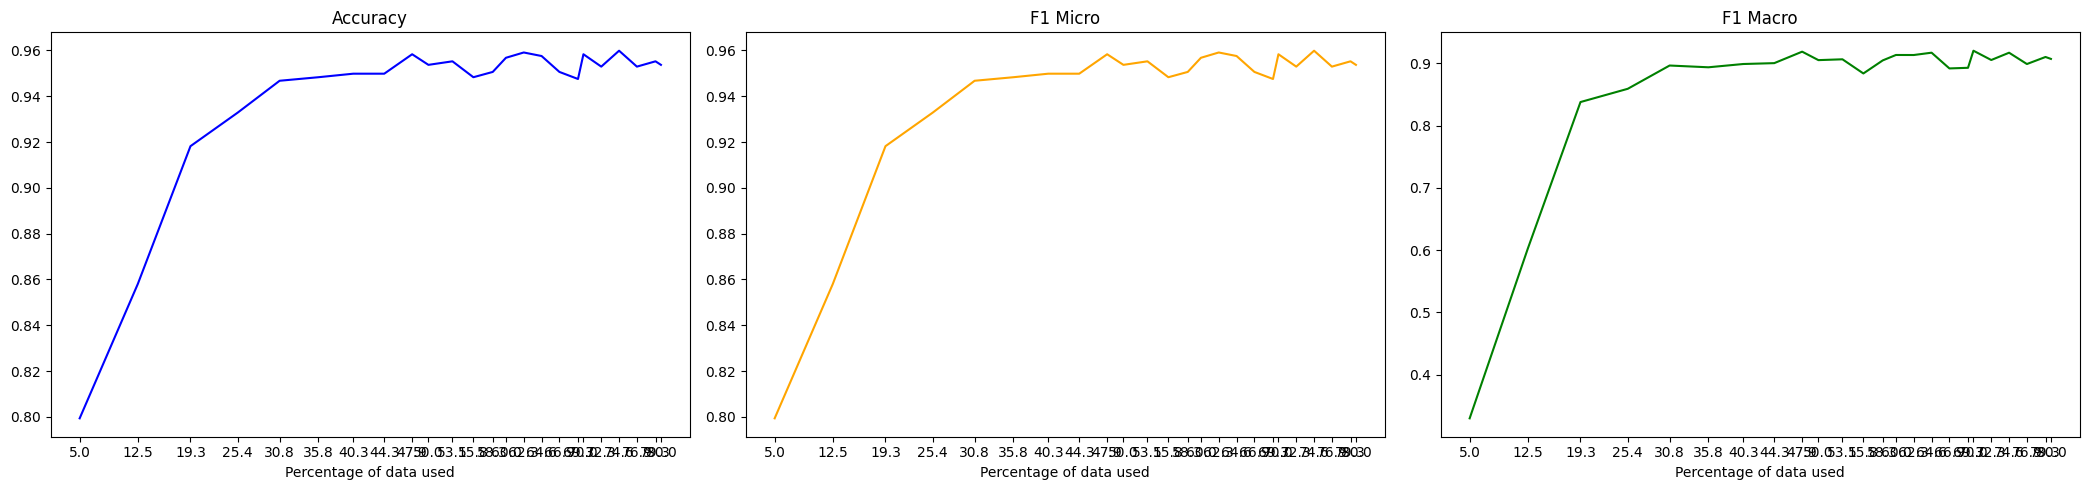

In [ ]:
active_learning(seeds[4], 4)